## Deep Learning project

- Gianfranco Di Marco - 1962292
- Giacomo Colizzi Coin - 1794538

\
**- Trajectory Prediction -**

Is the problem of predicting the short-term (1-3 seconds) and long-term (3-5 seconds) spatial coordinates of various road-agents such as cars, buses, pedestrians, rickshaws, and animals, etc. These road-agents have different dynamic behaviors that may correspond to aggressive or conservative driving styles.

**- nuScenes Dataset -**

Available at https://www.nuscenes.org/nuscenes. The nuScenes
dataset is a large-scale autonomous driving dataset. The dataset has 3D bounding boxes for 1000 scenes collected in Boston and Singapore. Each scene is 20 seconds long and annotated at 2Hz. This results in a total of 28130 samples for training, 6019 samples for validation and 6008 samples for testing. The dataset has the full autonomous vehicle data suite: 32-beam LiDAR, 6 cameras and radars with complete 360° coverage

> Holger Caesar and Varun Bankiti and Alex H. Lang and Sourabh Vora and Venice Erin Liong and Qiang Xu and Anush Krishnan and Yu Pan and Giancarlo Baldan and Oscar Beijbom: "_nuScenes: A multimodal dataset for autonomous driving_", arXiv preprint arXiv:1903.11027, 2019.

The most important part of this dataset for our project is the Map Expansion Pack, which simplifies the trajectory prediction problem

**- Baseline 1: CoverNet -**

One of the first models for the Trajectory Prediction problem with nuScenes dataset. Simply a CNN that extracts features from raster map images

> Tung Phan-Minh, Elena Corina Grigore, Freddy A. Boulton, Oscar Beijbom, Eric M. Wolff: "_CoverNet: Multimodal Behavior Prediction using Trajectory Sets_", arXiv:1911.10298
> , 2019.

**- Baseline 2: P2T -**

One of the most recent SOTA (actually 10-th position in the nuScenes benchmark) approaches for the Trajectory Prediction problem with nuScenes dataset. A combination of Inverse Reinforcement Learning on a grid representation of the maps, with a trajectory generator which encodes motion and grid-based plans, then decode the trajectories (the name P2T stands for "Plans 2 Trajectories")

> Nachiket Deo, Mohan M. Trivedi: "_Trajectory Forecasts in Unknown Environments Conditioned on Grid-Based Plans_", arXiv:2001.00735, 2020.


## Requirements


**Style**

Library useful to check PEP8 standard requirements

In [ ]:
CHECK_PEP8 = False

In [ ]:
if CHECK_PEP8:
    %pip -q install flake8 pycodestyle pycodestyle_magic
    %load_ext pycodestyle_magic
    %pycodestyle_on -m 79 -i W391

     |████████████████████████████████| 61 kB 503 kB/s 
     |████████████████████████████████| 41 kB 455 kB/s 
     |████████████████████████████████| 66 kB 4.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.


**Environment**


In [ ]:
"""
Necessary since Google Colab supports only Python 3.7
Furthermore,
   -> some libraries can be different between local and Colab
   -> resource usage is different between local and Colab
"""
try:
    import google.colab
    from google.colab import drive
    ENVIRONMENT = "colab"
    %pip -q install "tf-estimator-nightly == 2.8.0.dev2021122109"
    %pip -q install "folium == 0.2.1"
except Exception as e:
    ENVIRONMENT = "local"
    %pip -q install gdown

     |████████████████████████████████| 462 kB 17.1 MB/s 
     |████████████████████████████████| 69 kB 4.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.5 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.


INFO:pycodestyle:11:11: E225 missing whitespace around operator
INFO:pycodestyle:12:11: E225 missing whitespace around operator
INFO:pycodestyle:15:11: E225 missing whitespace around operator


**Libraries**


In [ ]:
%pip -q install nuscenes-devkit
%pip -q install pytorch-lightning

     |████████████████████████████████| 312 kB 33.0 MB/s 
     |████████████████████████████████| 87 kB 7.4 MB/s 
     |████████████████████████████████| 120 kB 65.4 MB/s 
     |████████████████████████████████| 1.6 MB 41.2 MB/s 
     |████████████████████████████████| 82 kB 849 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.17.5 requires folium>=0.9.1, but you have folium 0.2.1 which is incompatible.
     |████████████████████████████████| 708 kB 18.5 MB/s 
     |████████████████████████████████| 529 kB 48.9 MB/s 
     |████████████████████████████████| 5.9 MB 49.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220929150707 requires tensorboard<2.9,>=2.8, but you have tensorboard 2

In [ ]:
# Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torchvision.models import resnet50, resnet34
from torchvision.transforms import Normalize
from sklearn.cluster import KMeans
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Math
from pyquaternion import Quaternion
import numpy as np
import math

# Visual
import cv2
import matplotlib.pyplot as plt

# Dataset
from nuscenes.nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.helper import convert_local_coords_to_global
from nuscenes.prediction.helper import quaternion_yaw
from nuscenes.prediction.input_representation.utils import (
    convert_to_pixel_coords, get_crops, get_rotation_matrix)
from nuscenes.prediction.input_representation.interface import (
    InputRepresentation, AgentRepresentation)
from nuscenes.prediction.input_representation.static_layers import (
    StaticLayerRasterizer)
from nuscenes.prediction.input_representation.agents import (
    AgentBoxesWithFadedHistory)
from nuscenes.prediction.input_representation.combinators import Rasterizer
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.eval.prediction import metrics, data_classes

# File system
import os
import copy
import gdown
import shutil
import pickle
import zipfile
import tarfile
import urllib.request

# Logging
from torch.utils.tensorboard import SummaryWriter
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import warnings

# Generic
import time
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Any
from collections import defaultdict, namedtuple
from abc import abstractmethod
import multiprocessing as mp
from IPython.display import clear_output

## Configuration


**Generic Parameters**


In [ ]:
# Environment-dependent parameters
if ENVIRONMENT == "colab":
    ROOT = "/content"
    MAX_NUM_WORKERS = 0
    PROGRESS_BAR_REFRESH_RATE = 20
    MINI_DATASET = True
    if not MINI_DATASET:
        ROOT = "/content/drive/MyDrive/DL/Trajectory-Prediction-PyTorch/"
elif ENVIRONMENT == "local":
    ROOT = os.getcwd()
    # BUG: VRAM problem with PL
    if os.name == "nt":
        MAX_NUM_WORKERS = 0
    else:
        MAX_NUM_WORKERS = 8
    PROGRESS_BAR_REFRESH_RATE = 10
    MINI_DATASET = False
else:
    raise ValueError("Wrong 'environment' value")

# Generic Train parameters
NUM_WORKERS = MAX_NUM_WORKERS
PLOT_PERIOD = 1         # 1 = plot at each epoch
PRINT_PERIOD = 1        # 1 = print at each batch iter
CHECKPOINT_PERIOD = 1   # 1 = save model at each epoch
CHECKPOINT_METHOD = "best"
CHECKPOINT_MONITOR = "val_loss"
CHECKPOINT_DIR = os.path.join(ROOT, "checkpoints")
BEST_FOLDER = "best"
TOP_K_SAVE = 10

# Generic Test parameters
DEBUG_MODE = False

# Links
MAP_EXPANSION_LINK = ("https://drive.google.com/uc?id=1AFArWFDqSFKR4VDzWWm8bA1"
                      + "xaRF0NaPM")
MINI_DATASET_LINK = ("https://drive.google.com/uc?id=1eeQg3zfD-lGHRB8Fv6YLL4yV"
                     + "6xfCKEqd")
TRAINVAL_METADATA_LINK = ("https://drive.google.com/uc?id=1AFrvGYJ1X9y9uXsEk9A"
                          + "ohsjVjPNsI6Kj")
CHECKPOINTS_LINK = ("https://drive.google.com/uc?id=1eee_bqesa_pHoi_XxBa0hykZU"
                    + "JJFgFKj")
TRAJ_LINK = ("https://www.nuscenes.org/public/nuscenes-prediction-challenge-tr"
             + "ajectory-sets.zip")

**Network Parameters**


In [ ]:
# _________ CoverNet Parameters _________ #
# - Architecture parameters
BACKBONE_WEIGHTS = "ImageNet"
BACKBONE_MODEL = "ResNet18"
K_SIZE = 20000
# - Trajectory parameters
TRAJ_DIR = os.path.join(ROOT, "trajectory_sets")
EPSILON = 2
# Train Parameters
COVERNET_LR = 1e-4
COVERNET_MOMENTUM = 0.9
TRAIN_COVERNET_EPOCHES = 25
TRAIN_EPOCHES = 25

# _________ P2T Parameters _________ #
# - RL parameters
INITIAL_STATE = [19, 12]
POLICY_SAMPLES = 200
# - Reward Model parameters
TRAIN_RM_EPOCHES = 25
REWARD_MODEL_LR = 0.0001
RM_LOGNAME = "reward_model"
# - Trajectory Generator parameters
PRETRAIN_TG_EPOCHES = 80
TRAIN_TG_EPOCHES = 400
TRAJ_HIDDEN_SIZE = 32
PLAN_HIDDEN_SIZE = 32
ATT_HIDDEN_SIZE = 32
POS_EMBEDDING_SIZE = 16
SCENE_EMBEDDING_SIZE = 32
AGENT_EMBEDDING_SIZE = 16
SCENE_FEATURES_SIZE = 32
AGENT_FEATURES_SIZE = 4
DYN_FEATURES_SIZE = 3
ACTIVATION_SLOPE = 0.1
TRAJ_GEN_LR_PRE = 0.001
TRAJ_GEN_LR = 0.0001
TRAJ_CLUSTERS = 10
MAX_CLIP_NORM = 10
PRE_TG_LOGNAME = "traj_generator_pretrain"
FT_TG_LOGNAME = "traj_generator_finetune"

**Dataset Parameters**


In [ ]:
# Organization parameters
HELPER_LOADING = False
PREPARE_DATASET = False
PREPROCESSED = True

# File system parameters
PL_SEED = 42
DATAROOT = os.path.join(ROOT, "data", "sets", "nuscenes")
PREPROCESSED_FOLDER = "preprocessed"
PREPROCESSED_ADV_FOLDER = "preprocessed_advanced"
GT_SUFFIX = "-gt"
ADD_SUFFIX = "-add"
FILENAME_EXT = ".pt"
ADDITIONAL_EXT = ".npy"
AGGREGATORS = [{"name": "RowMean"}]
DATASET_VERSION = "v1.0-mini" if MINI_DATASET else "v1.0-trainval"

# NuScenes parameters
SHORT_AGENT_HISTORY = 1
LONG_AGENT_HISTORY = 2
SHORT_TERM_HORIZON = 3
LONG_TERM_HORIZON = 6
TRAJ_HORIZON = LONG_TERM_HORIZON
AGENT_HISTORY = LONG_AGENT_HISTORY
HORIZON_FOLDER = str(TRAJ_HORIZON) + "_seconds"
COMPUTE_OFFROADRATE = True

# Advanced parameters
GRID_SIDE = 25
GRID_EXTENT = [-25, 25, -10, 40]
RASTER_SIZE = 200
IMG_RESOLUTION = 0.1
MDP_HORIZON = 40

# Train parameters
BATCH_SIZE = 16

# Other parameters
MAX_PREDICTED_MODES = 25
SAMPLES_PER_SECOND = 2
NORMALIZATION = "imagenet"

**Fast setting (Google Colab only)**


Useful parameters to set before a Google Colab testing session (default values have been already assigned before):

> - `NUM_WORKERS`: the number of processes that collect data
> - `BATCH_SIZE`: number of dataset elements in a batch
> - `PLOT_PERIOD`: period of iterations to plot train data (debug only
> - `PRINT_PERIOD`: period of iterations to print training trend
> - `CHECKPOINT_PERIOD`: period of iterations to save model checkpoints
> - `HELPER_LOADING`: if you want to use the nuScenes helper to load the data (RAM consuming).
> - `PREPARE_DATASET`: if to prepare data on the disk. By default it is True, so the dataset will be prepared (if not already done) on the filesystem. Should be toggled to False after the first data preparation
> - `PREPROCESSED`: if the data has already been preprocessed. If False, the initialized datasets will be preprocessed, so make sure to toggle this flag to True if you have already preprocessed the data or you are using a plug-and-play dataset (for example by mounting on Drive)
> - `TRAJ_HORIZON`: the number of seconds of horizon to predict the trajectory of an agent
> - `AGENT_HISTORY`: the number of seconds of past of an agent to take into account for trajectory generation


In [ ]:
if ENVIRONMENT == "colab":

    # @markdown - Training Parameters
    NUM_WORKERS = 0  # @param {type:"slider", min:0, max:8, step:1}
    BATCH_SIZE = 16  # @param {type:"slider", min:1, max:64, step:1}
    PLOT_PERIOD = 1  # @param {type:"slider", min:1, max:10000, step:1}
    PRINT_PERIOD = 1  # @param {type:"slider", min:1, max:10000, step:1}
    CHECKPOINT_PERIOD = 1  # @param {type:"slider", min:1, max:10000, step:1}
    CHECKPOINT_METHOD = "best"  # @param ["best", "last"] {type:"string"}

    # @markdown - Dataset Parameters
    HELPER_LOADING = False  # @param {type: "boolean"}
    PREPARE_DATASET = True  # @param {type: "boolean"}
    PREPROCESSED = False  # @param {type: "boolean"}
    TRAJ_HORIZON = 6  # @param {type:"slider", min:3, max:6, step:3}
    AGENT_HISTORY = 2  # @param {type:"slider", min:1, max:2, step:1}

## Dataset


**Initialization**


First dataset option [recommended]: The following code prepares the dataset files on the disk. With the _MINI_DATASET_ option specified, it is possible to download a tiny split of the entire dataset in order to allow testing also on limiting runtimes (like the Google Colab one); this is the default option when running in Google Colab, because there isn't enough space to extract all the dataset.

N.B: If you haven't access to the Drive links, it's possible to use urllib.urlrequest to download correctly the files, through the function _urllib.request.urlretrieve()_ 

Steps to download correctly (**Firefox**):

1.  Dowload Map Expansion pack (or Trainval metadata) from the website
2.  Stop the download
3.  Right-click on the file -> copy download link
4.  Paste the copied link into the first argument of the urlretrieve function. The second argument is the final name of the file

Steps to download correctly (**Chrome**):

1.  Dowload Map Expansion pack (or Trainval metadata) from the website
2.  Click on "Show All" or go to the download section
3.  Right-click on the file link -> copy download link
4.  Paste the copied link into the first argument of the urlretrieve function. The second argument is the final name of the file

WARNING: sometimes the "maps" folder of the Map Expansion pack is overwritten by the "maps" folder extracted from the Metadata; this results into an error when loading the dataset helper in Main function. If this happens, try to restart runtime and retry the process


In [ ]:
if PREPARE_DATASET:

    # Creating dataset dir
    start = time.time()
    os.makedirs(DATAROOT, exist_ok=True)
    os.chdir(DATAROOT)

    # Downloading Map Expansion Pack
    if "maps" not in os.listdir():
        map_exp = "nuScenes-map-expansion-v1.3.zip"

        os.mkdir("maps")
        os.chdir("maps")
        print("Downloading and extracting Map Expansion pack ...")
        gdown.download(MAP_EXPANSION_LINK, map_exp, quiet=False)
        with zipfile.ZipFile(map_exp, "r") as zip_ref:
            zip_ref.extractall(os.getcwd())
        os.remove(map_exp)
        os.chdir("..")

    # If specified, use the mini dataset split
    if MINI_DATASET:
        mini_db = "v1.0-mini.tgz"

        # Downloading Mini-Trainval Metadata
        if "v1.0-mini" not in os.listdir():
            print("Downloading and extracting Mini dataset ...")
            gdown.download(MINI_DATASET_LINK, mini_db, quiet=False)
            with tarfile.open(mini_db, "r:gz") as tar_ref:
                tar_ref.extractall(os.getcwd())
            os.remove(mini_db)
            shutil.rmtree("samples")
            shutil.rmtree("sweeps")
            os.chdir(DATAROOT)
    else:
        full_db = "v1.0-trainval_meta.tgz"
        # Downloading Trainval Metadata
        if "v1.0-trainval" not in os.listdir():
            print("Downloading and extracting TrainVal metadata ...")
            gdown.download(TRAINVAL_METADATA_LINK, full_db, quiet=False)
            with tarfile.open(full_db, "r:gz") as tar_ref:
                tar_ref.extractall(os.getcwd())
            os.remove(full_db)
            os.chdir(DATAROOT)

    print(f"Dataset prepared in {time.time() - start}")

Second dataset option [not recommended]: in Google Colab, mount to Drive if you have access to the complete preprocessed dataset in a shared folder within your Google Drive filesystem.

N.B: Training is not feasible with the complete dataset on Google Colab, so if your intention is to iterate over all the dataset to test the model in this runtime (where it requires about 2/3 hours for each epoch), note that the default option for _MINI_DATASET_ is True, so this code will not execute. Remember that Mini Dataset is the best way to test the models in this environment.

Otherwise, if you just want to test or debug the complete dataset and check how it works on Colab with few baseline iterations on small dataset batches, please make sure to have access to the aforementioned shared folder, then restart runtime and toggle the _MINI_DATASET_ option to False in the Environment-dependent parameters.


In [ ]:
# Drive initialization
if ENVIRONMENT == "colab" and not MINI_DATASET:
    drive.mount("/content/drive")

**Dataset definition**


Here follow the PyTorch and PyTorch-Lightning dataset classes. The hierarchy is the following one:

```
|- TrajPredictionDataset
|------ nuScenesDataset
|----------- nuScenesAdvanced
```

```
|- TrajPredictionDataModule
|------ nuScenesDataModule
```

The first class of each hierarchy is just a base class with abstract methods only.

The nuScenes Dataset class is the main dataset class for this project; it allows a basic data preprocessing and a batch is composed by few essential things like the agent state vector or the raster map image.

The nuScenesAdvanced class, instead, is an advanced representation that allows to handle grid representations of raster maps, and is more complex than the previous one. In order to avoid problems in using either one dataset or the other, it's convenient to preprocess different datasets in different folders, despite the fact that a model trained on a basic dataset can also execute with an advanced dataset; this is because if the datasets are generated with different image resolution, there is data loss and is difficult to restore image's original resolution at execution time.

Regarding the PyTorch-Lightning data modules, instead, it's very convenient to use them, in order to train the models and avoiding to write superfluous code for the basic pytorch functionalities, or just encapsulate all the different splits of a dataset.


In [ ]:
class TrajPredictionDataset(torch.utils.data.Dataset):
    """ Trajectory Prediction Dataset

    Base Class for Trajectory Prediction Datasets
    """

    def __init__(self, dataset, name, data_type, preprocessed, split,
                 dataroot, preprocessed_folder, horizon_folder, filename_ext,
                 gt_suffix, traj_horizon, max_traj_horizon, num_workers):
        """ Dataset Initialization

        Parameters
        ----------
        dataset: the instantiated dataset
        name: name of the dataset
        data_type: data type of the dataset elements
        preprocessed: True if data has already been preprocessed
        split: the dataset split ("environment", "train", "train_val")
        dataroot: the root directory of the dataset
        preprocessed_folder: the folder containing preprocessed data
        horizon_folder: the folder relative to the actual trajectory horizon
        filename_ext: the extension of the generated filenames
        gt_suffix: the suffix added after each GT filename (before ext)
        traj_horizon: horizon (in seconds) for the future trajectory
        max_traj_horizon: maximum trajectory horizon possible (in seconds)
        num_workers: num of processes that collect data
        """
        super(TrajPredictionDataset, self).__init__()
        self.time = {}
        self.dataset = dataset
        self.name = name
        self.data_type = data_type
        self.preprocessed = preprocessed
        self.split = split
        self.dataroot = dataroot
        self.preprocessed_folder = preprocessed_folder
        self.horizon_folder = horizon_folder
        self.filename_ext = filename_ext
        self.gt_suffix = gt_suffix
        self.traj_horizon = traj_horizon
        self.max_traj_horizon = max_traj_horizon
        self.num_workers = num_workers

    def __len__(self):
        """ Return the size of the dataset """
        raise NotImplementedError

    def __getitem__(self, idx):
        """ Return an element of the dataset """
        raise NotImplementedError

    @abstractmethod
    def generate_data(self):
        """ Data generation

        If self.preprocessed, directly collect data.
        Otherwise, generate data and preprocess it.
        """
        raise NotImplementedError

In [ ]:
class TrajPredictionDataModule(pl.LightningDataModule):
    """ PyTorch Lightning Data Module for the Trajectory Prediction Problem """

    def __init__(self, train_dataset: TrajPredictionDataset,
                 val_dataset: TrajPredictionDataset, test_dataset=None,
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        """ Data Module initialization

        Parameters
        ----------
        train_dataset: instance of the train dataset class
        val_dataset: instance of the val dataset class
        test_dataset: instance of the test dataset class
        batch_size: number of samples to extract from the dataset at each step
        num_workers: number of cores implied in data collection
        """
        super(TrajPredictionDataModule, self).__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        if test_dataset is None:
            self.test_dataset = val_dataset
        self.batch_size = batch_size
        self.num_workers = num_workers

    @abstractmethod
    def setup(self, stage=None):
        """ Setup the data module """
        raise NotImplementedError

    @abstractmethod
    def train_dataloader(self):
        """ Dataloader for the training part """
        raise NotImplementedError

    @abstractmethod
    def val_dataloader(self):
        """ Dataloader for the validation part """
        raise NotImplementedError

    @abstractmethod
    def test_dataloader(self):
        """ Dataloader for the testing part """
        raise NotImplementedError

This class is the core of the whole Dataset. Here the most important data is first preprocessed (before the training) and than collected during the execution. The main features provided by this class are:

*   **Data preprocessing**: store all the data needed for training and inference on the disk; data is divided in different subfolders, named as "batch_x" (with x name of the batch) in order to allow the storage on Google Drive and avoid mounting timeouts. The purpose of preprocessing is to save training time, because it's expensive for the nuScenes helper to make at every iteration a raster representation of the mapped scenes. There is a fundamental difference between this implementation and the original one (but also other implementation of the nuScenes dataset): not only the raster images are preprocessed, but also all the remaining data, like agent state vector and ground truth, which are stored as tensor data; in particular, the agent state vector is concatenated with the raster map through the *tensor_io_conversion* function, which allows to concatenate tensors of different shape in order to store them efficiently and avoid too many memory accesses. This implementation choice is fundamental because it makes possible to train and validate the model without the use of the nuScenes helper, that is really memory expensive (around 10GB of RAM to initialize it). Anyway, there is the possibility to train also with the helper by specifying the *HELPER_LOADING* parameter.
*   **Data collection**: the *getitem* method retuns the raster map (both dynamic and static, if needed), agent state vector (containing velocity, acceleration and yaw rate) and the ground truth trajectory. The data collection is robust because there is also a function that checks the parameters needed to collect data, and in case they are not consistent or not sufficient to reach the subfolder in which the data is contained, it tries anyway to find it or it raises an exception.
*   **Tensor IO conversion**: As stated before, there is a function in this class that allows to concatenate tensors of different shape. Of course, this can be used also for other purposes, so it's an interesting feature in each case.
*   **Time dictionary management**: Another important feature provided by this class is the time dictionary, that is a python dict that shows all the relative execution times of the most important snippet of code of the dataset, like the function to get the agent raster or the function to normalize data. This can be really useful in order to make efficiency comparisons both with the code and the models.



In [ ]:
class nuScenesDataset(TrajPredictionDataset):
    """ nuScenes Dataset for Trajectory Prediction challenge """

    def __init__(self, helper: PredictHelper, data_type="raster",
                 preprocessed=False, split="train", dataroot=DATAROOT,
                 preprocessed_folder=PREPROCESSED_FOLDER,
                 horizon_folder=HORIZON_FOLDER, filename_ext=FILENAME_EXT,
                 gt_suffix=GT_SUFFIX, include_static=False,
                 img_resolution=IMG_RESOLUTION, traj_horizon=TRAJ_HORIZON,
                 max_traj_horizon=LONG_TERM_HORIZON,
                 samples_per_second=SAMPLES_PER_SECOND,
                 normalization=NORMALIZATION, helper_loading=HELPER_LOADING,
                 num_workers=NUM_WORKERS):
        """ nuScenes Dataset Initialization

        Parameters
        ----------
        helper: the helper of the instantiated
                nuScenes dataset (None if not needed)
        data_type: data type of the dataset elements
        preprocessed: True if data has already been preprocessed
        split: the dataset split ("train_val", "val", "raster")
        dataroot: the root directory of the dataset
        preprocessed_folder: the folder containing preprocessed data
        horizon_folder: the folder relative to the actual trajectory horizon
        filename_ext: the extension of the generated filenames
        gt_suffix: the suffix added after each GT filename (before ext)
        include_static: if to return also static rasters in __getitem__
        img_resolution: resolution of the generated
                        raster image (in meters/pixel)
        traj_horizon: horizon (in seconds) for the future trajectory
        max_traj_horizon: maximum trajectory horizon possible (in seconds)
        samples_per_second: sampling frequency (in Hertz)
        normalization: which kind of normalization to apply to input
        helper_loading: True if to load data only with helper
        num_workers: num of processes that collect data
        """
        # General initialization
        super(nuScenesDataset, self).__init__(
            None, "train", data_type, preprocessed, split, dataroot,
            preprocessed_folder, horizon_folder, filename_ext,
            gt_suffix, traj_horizon, max_traj_horizon, num_workers)
        self.time["training:get_item"] = 0
        self.time["get_item:indicize_token"] = 0
        self.time["get_item:get_agent_raster"] = 0
        self.time["get_item:load_gt"] = 0
        self.time["get_item:normalization"] = 0
        self.tokens = get_prediction_challenge_split(split, dataroot=dataroot)
        self.helper = helper
        self.include_static = include_static
        self.samples_per_second = samples_per_second
        self.helper_loading = helper_loading
        if data_type == "raster":
            if helper is not None:
                self.static_layer_rasterizer = StaticLayerRasterizer(
                    self.helper, resolution=img_resolution)
                self.agent_rasterizer = AgentBoxesWithFadedHistory(
                    self.helper, seconds_of_history=1,
                    resolution=img_resolution)
                self.input_representation = InputRepresentation(
                    self.static_layer_rasterizer, self.agent_rasterizer,
                    Rasterizer())
            else:
                self.static_layer_rasterizer = None
                self.agent_rasterizer = None
                self.input_representation = None
        else:   # NOTE: possible also other type of input data
            pass
        if not self.preprocessed:
            print("Generating and Preprocessing data ...")
            self.generate_data()
            self.preprocessed = True
            if not helper_loading:
                self.helper = None

        # Normalization function
        if normalization == "imagenet":
            self.normalization = Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        else:
            raise ValueError("Available only 'imagenet' normalization")

    def __len__(self) -> int:
        """ Return the size of the dataset """
        return len(self.tokens)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor,
                                        torch.Tensor, torch.Tensor, int]:
        """ Return an element of the dataset

        Parameters
        ----------
        idx: index of the element

        Return
        ------
        agent_state_vector: vector [velocity, acceleration, yaw rate]
                            of the target agent
        raster_img_static: raster map of the scene, with only static element
                           (empty if not self.include_static)
        raster_img_dynamic: raster map of the scene,
                            complete with dynamic elements
        gt_trajectory: ground truth of the agent (agent future)
        idx: index of the element
        """
        self.time["training:get_item"] -= time.time()
        self.time["get_item:get_agent_raster"] -= time.time()

        # Get agent state vector and raster
        agent_state_vector, raster_img = self.get_agent_raster(idx=idx)
        self.time["get_item:get_agent_raster"] += time.time()

        # Load GT trajectory
        self.time["get_item:load_gt"] -= time.time()
        gt_trajectory = self.get_agent_future(idx=idx)
        gt_trajectory = gt_trajectory[:(
            self.samples_per_second * self.traj_horizon)]
        self.time["get_item:load_gt"] += time.time()

        self.time["get_item:normalization"] -= time.time()
        # Include static data and normalize
        if not self.include_static:
            raster_img_dynamic = raster_img
            raster_img_static = torch.empty((0,))
        else:
            # NOTE: this should be adapted also to non-square images
            raster_img_static, raster_img_dynamic = raster_img.split(
                raster_img.shape[-1], dim=1)
            raster_img_static = self.normalization(raster_img_static)
        raster_img_dynamic = self.normalization(raster_img_dynamic)
        self.time["get_item:normalization"] += time.time()

        self.time["training:get_item"] += time.time()
        return (agent_state_vector, raster_img_static, raster_img_dynamic,
                gt_trajectory, idx)

    def generate_data(self):
        """ Data generation

        If self.preprocessed, directly collect data.
        Otherwise, generate data and preprocess it.
        """
        # Generate directories if don't exist
        preprocessed_dir = os.path.join(
            self.dataroot, self.preprocessed_folder)
        split_dir = os.path.join(preprocessed_dir, self.split)
        if self.preprocessed_folder not in os.listdir(self.dataroot):
            os.mkdir(preprocessed_dir)
        if self.split not in os.listdir(preprocessed_dir):
            os.mkdir(split_dir)

        # Variable useful to restore interrupted preprocessing
        preprocessed_batches = os.listdir(split_dir)
        already_preproc = len([f for batch in preprocessed_batches for f in
                               os.listdir(os.path.join(split_dir, batch))
                               if os.path.isfile(os.path.join(split_dir,
                                                              batch, f))])

        # Create subfolders
        if len(preprocessed_batches) == 0:
            n_subfolders = len(self.tokens) // 128 + \
                int(len(self.tokens) % 128 != 0)
            for i in range(n_subfolders):
                subfolder = "batch_" + str(i)
                os.mkdir(os.path.join(split_dir, subfolder))

        # Generate data
        if self.data_type == "raster":
            for i, t in enumerate(tqdm(self.tokens)):
                subfolder = f"batch_{i//128}"
                if i >= int(already_preproc/2):
                    self.generate_raster_data(t, split_dir, subfolder)
        else:
            pass

    def generate_raster_data(self, token, batches_dir, subfolder):
        """ Generate raster and agent data from a dataset token

        The generated input data consists in a tensor like this:
            [raster map | agent state vector]
        The generated ground truth data is the future agent trajectory tensor

        Parameters
        ----------
        token: token containing instance token and sample token
        batches_dir: the directory in which the batches will be generated
        subfolder: the data is divided into subfolders in order to avoid Drive
                   timeouts; this parameter tells which is the actual subfolder
                   towhere place data
        """
        # Generate agent state, raster img and GT
        # (raster img both static and dynamic if self.include_static = True)
        instance_token, sample_token = token.split("_")
        agent_state_vector, raster_tensor = self.get_agent_raster(
            instance_token, sample_token)
        gt_trajectory = self.get_agent_future(
            instance_token, sample_token, traj_horizon=self.max_traj_horizon)

        # Concatenate raster and state, then save all to disk
        raster_agent_tensor, _ = self.tensor_io_conversion(
            "write", raster_tensor, agent_state_vector)
        torch.save(raster_agent_tensor, os.path.join(
            batches_dir, subfolder, token + self.filename_ext))
        torch.save(gt_trajectory, os.path.join(batches_dir, subfolder, token
                                               + self.gt_suffix
                                               + self.filename_ext))

    def get_agent_raster(self, i_t=None, s_t=None,
                         subfolder=None, idx=None,
                         state_only=False) -> Tuple[torch.Tensor,
                                                    torch.Tensor]:
        """ Return agent state vector and raster image

        Parameters
        ----------
        i_t: instance_token
        s_t: sample_token
        subfolder: the subfolder in which is contained the element
        idx: eventual idx of the dataset element
        state_only: True if to return only the agent state

        Return
        ------
        agent_state_vector: vector [velocity, acceleration, yaw rate]
                            of the target agent
        raster_img: raster image (both static and dynamic if
                    self.include_static=True)
        """
        # Select subfolder and check parameters
        i_t, s_t, subfolder, _ = self.check_get_params(
            i_t, s_t, subfolder, idx)

        # Load files
        if self.helper is not None:
            # Generate agent state
            agent_state_vector = torch.Tensor(
                [[self.helper.get_velocity_for_agent(i_t, s_t),
                  self.helper.get_acceleration_for_agent(i_t, s_t),
                  self.helper.get_heading_change_rate_for_agent(i_t, s_t)]])
            # Handle nan values
            nan_mask = agent_state_vector != agent_state_vector
            if nan_mask.any():
                agent_state_vector[nan_mask] = 0
            # Generate raster img if not only state
            if state_only:
                raster_tensor = torch.empty((0,))
            else:
                raster_img = (self.input_representation.
                              make_input_representation(i_t, s_t))
                raster_tensor = torch.from_numpy(
                    raster_img).permute(2, 0, 1) / 255.
                # Generate also static raster image
                if self.include_static:
                    raster_img_static = (self.static_layer_rasterizer.
                                         make_representation(i_t, s_t))
                    raster_tensor_static = torch.from_numpy(
                        raster_img_static).permute(2, 0, 1) / 255.
                    raster_tensor = torch.cat(
                        [raster_tensor_static, raster_tensor], dim=1)
        else:
            # Load agent state and raster img from disk
            complete_tensor = torch.load(os.path.join(
                self.dataroot, self.preprocessed_folder, self.split, subfolder,
                i_t + "_" + s_t + self.filename_ext))
            # Separate state and rasters
            agent_state_vector, raster_tensor = self.tensor_io_conversion(
                "read", None, None, complete_tensor)

        return agent_state_vector, raster_tensor

    def get_agent_future(self, i_t=None, s_t=None, subfolder=None,
                         idx=None, in_agent_frame=True,
                         traj_horizon=LONG_TERM_HORIZON) -> torch.Tensor:
        """ Return ground truth trajectory of the agent

        Parameters
        ----------
        i_t: instance_token
        s_t: sampl_token
        subfolder: the subfolder in which is contained the element
        idx: eventual idx of the dataset element
        in_agent_frame: True if the coordinates are expressed in agent frame
        traj_horizon: the horizon (in seconds) of the trajectory to generate

        Return
        ------
        gt_trajectory: ground truth of the agent (agent future)
        """
        # Select subfolder and check parameters
        i_t, s_t, subfolder, _ = self.check_get_params(
            i_t, s_t, subfolder, idx)

        if self.helper is not None:
            # Generate ground truth trajectory
            gt_trajectory = torch.tensor(self.helper.get_future_for_agent(
                i_t, s_t, seconds=traj_horizon,
                in_agent_frame=in_agent_frame))
            # Handle incomplete GT
            if traj_horizon <= self.max_traj_horizon:
                while gt_trajectory.shape[0] < (self.samples_per_second
                                                * self.max_traj_horizon):
                    gt_trajectory = torch.concat(
                        (gt_trajectory, gt_trajectory[-1].unsqueeze(0)))
        else:
            # Load GT from disk
            gt_trajectory = torch.load(
                os.path.join(self.dataroot, self.preprocessed_folder,
                             self.split, subfolder, i_t + "_" + s_t
                             + self.gt_suffix + self.filename_ext))

        return gt_trajectory

    def check_get_params(self, i_t, s_t, subfolder, idx):
        """ Check and adjust parameters for get functions

        Parameters
        ----------
        i_t: instance token
        s_t: sample token
        subfolder: data subfolder
        idx: index of the dataset element

        Return
        ------
        i_t: instance token (eventually correct)
        s_t: sample token (eventually correct)
        subfolder: subfolder of the data (eventually computed)
        """
        # Select subfolder and check parameters
        if (i_t is None or s_t is None) and idx is not None:
            if idx < 0:
                idx = len(self) + idx
            i_t, s_t = self.tokens[idx].split("_")
        elif idx is None:
            if (i_t is None or s_t is None):
                raise ValueError("No params specified to deduce subfolder")
            elif self.helper is None:
                idx = self.tokens.index(i_t + '_' + s_t)
        if subfolder is None and self.helper is None:
            subfolder = f"batch_{idx//128}"
        return i_t, s_t, subfolder, idx

    @staticmethod
    def tensor_io_conversion(mode, big_t=None,
                             small_t=None,
                             complete_t=None) -> Tuple[torch.Tensor,
                                                       torch.Tensor]:
        """ Utility IO function to concatenate tensors of different shape

        Normally used to concatenate (or separate) raster map
        and agent state vector in order to speed up IO

        Parameters
        ----------
        mode: "write" (concatenate) or "read" (separate)
        big_t: the bigger tensor (None if we are going to separate tensors)
        small_t: the smaller tensor (None if we are going to separate tensors)
        complete_t: the concatenated tensor
                    (None if we are going to concatenate tensors)

        Return
        ------
        out1: small tensor (mode == "read")
              or complete tensor (mode == "write")
        out2: big tensor (mode == "read")
              or empty tensor (mode == "write")
        """
        out1, out2 = None, None
        if mode == "write":    # concatenate
            if big_t is None or small_t is None:
                raise ValueError(
                    "Wrong argument: 'big_t' and 'small_t' cannot be None")
            small_t = small_t.permute(1, 0).unsqueeze(2)
            small_t = small_t.expand(-1, -1, big_t.shape[-1])
            out1 = torch.cat((big_t, small_t), dim=1)
            out2 = torch.empty(small_t.shape)
        elif mode == "read":    # separate
            if complete_t is None:
                raise ValueError("Wrong argument: 'complete_t' cannot be None")
            out1 = complete_t[..., -1, -1].unsqueeze(0)
            out2 = complete_t[..., :-1, :]
        else:
            raise ValueError(
                "Wrong argument 'mode'; available 'read' or 'write'")
        return out1, out2

    @staticmethod
    def read_time_dict(time_dict: dict, overall=None, parent=None,
                       indent: str = "", general: bool = False,
                       res: str = "") -> str:
        """ Recursively extracts a multiline string describing
        the time distribution of each block of code measured by a dictionary

        Parameters
        ----------
        time_dict: the dictionary. Its keys are like
                   "parent:child" and its values are expressed in seconds
        overall: time for whole computation if general
                 else time for parent computation
        parent: the parent name
        indent: indentation character to use
        general: whether if scaling all results wrt
                 the whole or the parent's computation time
        res: current output string

        Return
        ------
        res: final output string
        """
        if time_dict == {}:
            return res
        time_list = list(time_dict.items())
        for k, v in time_list:
            if parent is None and ":" not in k:
                res += indent + f"{k} = {v:.3f}s\n"
                new_p = k
                overall = v
            elif parent is not None and k.startswith(parent):
                if overall is None:
                    res += indent + f"{k.split(':')[1]} = {v:.3f}s\n"
                else:
                    res += (indent
                            + f"{k.split(':')[1]} = {v/overall*100:.1f}%\n")
                new_p = k.split(":")[1]
            else:
                continue
            new_t = time_dict.copy()
            new_t.pop(k, 0)
            new_v = overall if general else v
            res = nuScenesDataset.read_time_dict(
                new_t, new_v, new_p, indent + "  ", general, res)
        return res

Here ve have the advanced version of the nuScenes dataset, dedicated to the P2T baselines which exploits a grid representation of the scene in order to make plans and predictions. Trivially, it provides all the functionalities of the father class, integrated with the ones specified in the original paper that are needed to extract useful data like state visitation frequencies, motion features, past history, and so on. Also for this class there is the possibility to train either with the helper or without it, by the exploitation of a dictionary named "additional_data", that encapsulates all the necessary data not generated during the father class dataset generation process.

Some functions are an adaptation of the P2T authors' implementation, but in the majority of code an improvement was made in terms of PyTorch parallelization and efficiency, by avoiding for loops and other sequential operations, converted in vectorized operations.

At the bottom of the cell, we can find also the *GridRepresentation* class, which is an *AgentRepresentation* subclass allowing to represent the scene as a grid. The remaining informations can be found inside the code.

In [ ]:
class nuScenesAdvanced(nuScenesDataset):
    """ nuScenes Advanced Dataset class """

    def __init__(self, helper: PredictHelper, data_type="raster",
                 preprocessed=False, split="train", dataroot=DATAROOT,
                 preprocessed_folder=PREPROCESSED_ADV_FOLDER,
                 horizon_folder=HORIZON_FOLDER, filename_ext=FILENAME_EXT,
                 additional_ext=ADDITIONAL_EXT, gt_suffix=GT_SUFFIX,
                 add_suffix=ADD_SUFFIX, include_static=True,
                 img_size=RASTER_SIZE, traj_horizon=TRAJ_HORIZON,
                 mdp_horizon=MDP_HORIZON, max_traj_horizon=LONG_TERM_HORIZON,
                 agent_history=AGENT_HISTORY,
                 max_agent_history=LONG_AGENT_HISTORY,
                 samples_per_second=SAMPLES_PER_SECOND,
                 normalization=NORMALIZATION, helper_loading=HELPER_LOADING,
                 grid_side=GRID_SIDE, grid_extent=GRID_EXTENT,
                 num_workers=NUM_WORKERS):
        """ nuScenes Advanced Dataset Initialization

        Parameters
        ----------
        helper: the helper of the instantiated nuScenes dataset
                (None if not needed)
        data_type: data type of the dataset elements
        preprocessed: True if data has already been preprocessed
        split: the dataset split ("train", "train_val", "val")
        dataroot: the root directory of the dataset
        preprocessed_folder: the folder containing preprocessed data
        horizon_folder: the folder relative to the actual trajectory horizon
        filename_ext: the extension of the generated filenames
        additional_ext: the extenstion of the generated additional files
        gt_suffix: the suffix added after each GT filename (before ext)
        add_suffix: the suffix added after each ADD filename (before ext)
        include_static: if to return also static rasters in __getitem__
        img_size: size of the raster map extracted from the dataset
        traj_horizon: horizon (in seconds) for the future trajectory
        mdp_horizon: horizon (in seconds) for the MDP
        max_traj_horizon: maximum trajectory horizon possible (in seconds)
        agent_history: the seconds of considered agent history
        max_agent_history: maximum history tracked for an agent (in seconds)
        samples_per_second: sampling frequency (in Hertz)
        normalization: which kind of normalization to apply to input
        helper_loading: True if to load data only with helper
        grid_side: side of the square grid
        grid_extent: extension of the grid for eventual map discretization
        num_workers: num of processes that collect data
        """
        # Advanced setting
        self.img_size = img_size
        self.grid_side = grid_side
        self.mdp_horizon = mdp_horizon
        self.agent_history = agent_history
        self.max_agent_history = max_agent_history
        self.additional_ext = additional_ext
        self.add_suffix = add_suffix
        self.grid_extent = torch.tensor(grid_extent)
        self.grid_size = grid_extent[1] - grid_extent[0]
        self.img_resolution = self.grid_size / img_size
        self.row_centers = torch.linspace(self.grid_extent[3] - self.grid_size
                                          / (self.grid_side * 2),
                                          self.grid_extent[2] + self.grid_size
                                          / (self.grid_side * 2),
                                          self.grid_side)
        self.col_centers = torch.linspace(self.grid_extent[0] + self.grid_size
                                          / (self.grid_side * 2),
                                          self.grid_extent[1] - self.grid_size
                                          / (self.grid_side * 2),
                                          self.grid_side)
        self.centers = torch.stack([self.col_centers, self.row_centers], 0)

        # Basic initialization
        super(nuScenesAdvanced, self).__init__(
            helper, data_type, preprocessed, split, dataroot,
            preprocessed_folder, horizon_folder, filename_ext,
            gt_suffix, include_static, self.img_resolution,
            traj_horizon, max_traj_horizon, samples_per_second,
            normalization, helper_loading, num_workers)
        self.time["get_item:nuscenesDataset"] = 0
        self.time["get_item:expert_data"] = 0
        self.time["get_item:add_data"] = 0
        self.time["get_item:surrounding_agents"] = 0
        self.time["get_item:agent_past"] = 0
        self.time["get_item:future_indefinite"] = 0
        self.time["get_item:motion_feats"] = 0

        # Grid initialization
        self.grid_representation = (GridRepresentation(
            helper, resolution=self.img_resolution,
            meters_ahead=grid_extent[3], meters_behind=-grid_extent[2],
            meters_left=-grid_extent[0], meters_right=grid_extent[1]))

    def __getitem__(self, idx):
        """ Return an element of the dataset

        Parameters
        ----------
        idx: index of the element

        Return
        ------
        agent_state_vector: vector [velocity, acceleration, yaw rate]
                            of the target agent
        raster_img_static: raster map of the scene, with only static element
                           (empty if not self.include_static)
        raster_img_dynamic: raster map of the scene,
                            complete with dynamic elements
        gt_trajectory: ground truth of the agent (agent future)
        idx: index of the element
        past: history of positions and states of the agent
        surr_agents: array containing the grid representation (4-channel image)
                     with surrounding agents features
        svf_e: expert State Visitation Frequencies tensor
        plan_e: expert Plan (waypoints) tensor
        grid_idcs: tensor of grid indices related to the plan
        motion_feats: position and velocity informations over the grid
        """
        # Select subfolder
        if idx < 0:
            idx = len(self) + idx
        subfolder = f"batch_{idx//128}"
        i_t, s_t = self.tokens[idx].split("_")

        # Get basic data
        self.time["get_item:nuscenesDataset"] -= time.time()
        (agent_state_vector, raster_img_static, raster_img_dynamic,
         gt_trajectory, idx) = super().__getitem__(idx)
        self.time["get_item:nuscenesDataset"] += time.time()
        self.time["training:get_item"] -= time.time()

        # Get additional data
        self.time["get_item:add_data"] -= time.time()
        add_data = self.get_add_data(i_t, s_t, subfolder)
        self.time["get_item:add_data"] += time.time()

        # Get surrounding agents representation
        self.time["get_item:surrounding_agents"] -= time.time()
        self.grid_representation.time = self.time
        surr_agents = (self.grid_representation.
                       make_representation(i_t, s_t,
                                           add_data["annotations"],
                                           add_data["ann_states"],
                                           add_data["sample_annotation"]))
        surr_agents = surr_agents.permute((2, 0, 1)).float()
        self.time = self.grid_representation.time
        self.time["get_item:surrounding_agents"] += time.time()

        # Downsample to grid dimensions with avg pooling
        surr_agents = F.avg_pool2d(surr_agents.unsqueeze(
            0), self.img_size // self.grid_side)
        surr_agents = surr_agents.squeeze(
            0) * ((self.img_size // self.grid_side) ** 2)

        # Manage agent's past
        self.time["get_item:agent_past"] -= time.time()
        past = self.manage_past(
            add_data["xy_past"], add_data["complete_past"], i_t, s_t)
        self.time["get_item:agent_past"] += time.time()

        # Upsample future indefinite
        self.time["get_item:future_indefinite"] -= time.time()
        future_indefinite = add_data["future_indefinite"]
        fp = np.concatenate(([[0, 0]], future_indefinite))
        x = np.linspace(
            0, future_indefinite.shape[0], future_indefinite.shape[0] * 10 + 1)
        xp = np.linspace(
            0, future_indefinite.shape[0], future_indefinite.shape[0] + 1)
        future_upsampled = torch.from_numpy(np.stack([np.interp(x, xp,
                                                                fp[..., 0]),
                                                      np.interp(x, xp,
                                                                fp[..., 1])],
                                                     axis=-1))
        self.time["get_item:future_indefinite"] += time.time()

        # Extract expert data
        self.time["get_item:expert_data"] -= time.time()
        svf_e, plan_e, grid_idcs = self.extract_expert_data(future_upsampled)
        self.time["get_item:expert_data"] += time.time()

        # Extract motion features
        self.time["get_item:motion_feats"] -= time.time()
        motion_feats = self.extract_motion_feats(agent_state_vector[0][0])
        self.time["get_item:motion_feats"] += time.time()
        self.time["training:get_item"] += time.time()

        return (agent_state_vector, raster_img_static, raster_img_dynamic,
                gt_trajectory, idx, past, surr_agents, svf_e, plan_e,
                grid_idcs, motion_feats)

    def manage_past(self, xy_past, complete_past,
                    instance_token, sample_token) -> torch.Tensor:
        """ Manage past and add dynamic features

        Parameters
        ----------
        xy_past: agent's past consisting only in waypoints
        complete_past: agent's past with complete informations
        instance_token: Instance token
        sample_token: Sample token

        Return
        ------
        past: enhanced past tensor
        """
        # Adjust past shape
        num_samples = self.agent_history * self.samples_per_second
        xy_past = xy_past[0:min(xy_past.shape[0], num_samples)]
        complete_past = complete_past[0:min(len(complete_past), num_samples)]

        # Set tokens from the past
        i_ts = [complete_past[i]["instance_token"]
                for i in range(len(complete_past))]
        s_ts = [complete_past[i]["sample_token"]
                for i in range(len(complete_past))]
        i_ts = [instance_token] + i_ts
        s_ts = [sample_token] + s_ts

        # Initialize past
        past = torch.zeros((xy_past.shape[0], 5), dtype=torch.float32)
        past[:, 0:2] = xy_past

        # Fill the past with dynamic values
        for i in range(xy_past.shape[0]):
            i_t = i_ts[i]
            s_t = s_ts[i]
            try:
                agent_state_vector = self.get_agent_raster(
                    i_t, s_t, state_only=True)[0]
                past[i, 2:5] = agent_state_vector[0]
            except Exception as e:
                agent_state_vector = None
                continue

        # Zero-padding when tracked history < agent history
        past_zeropadded = torch.cat(
            (past, torch.zeros((num_samples - past.shape[0], 5))), dim=0)
        past_zeropadded_flipped = past_zeropadded.flip([0])

        return past_zeropadded_flipped

    def extract_expert_data(self, future_upsampled: torch.Tensor) -> (
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        """ Extract expert SVF and plan, looking at the future trajectory

        Parameters
        ----------
        future_upsampled: future trajectory, upsampled by a factor of 10

        Return
        ------
        svf_e: expert State Visitation Frequencies tensor
        plan_e: expert Plan (waypoints) tensor
        grid_idcs: tensor of grid indices related to the plan
        """
        # Expert data intialization
        svf_e = torch.zeros((2, self.grid_side, self.grid_side))
        plan_e = torch.zeros((self.mdp_horizon, 2))
        grid_idcs = torch.zeros((self.mdp_horizon, 2))

        # Other intializations
        column_old = None
        row_old = None
        count = 0

        # Expert data extraction
        min_grid = self.grid_extent[[0, 2]]
        max_grid = self.grid_extent[[1, 3]]
        # out of frame points in future_upsampled
        out_grid = torch.logical_or(
            future_upsampled < min_grid, future_upsampled > max_grid)
        # future upsampled reduction to first n points in frame
        try:
            split_index = torch.arange(0, future_upsampled.shape[0])[
                out_grid.any(1)][0]
            reduced_future = torch.split(future_upsampled, split_index)[0]
        except Exception as e:
            reduced_future = future_upsampled
        # closest indices to centers in future_upsampled
        grid_new = torch.argmin(torch.abs(reduced_future.unsqueeze(-1)
                                          - self.centers),
                                dim=-1).type(torch.int64)
        # slowest portion (probably unboostable)
        # remove consecutive occurences
        reduced_grid_new = torch.unique_consecutive(grid_new, dim=0)

        # plan and grid_idcs assignments
        if self.mdp_horizon > reduced_grid_new.shape[0]:
            plan_e[:reduced_grid_new.shape[0]] = (
                torch.gather(self.centers, 1,
                             reduced_grid_new.permute(1,
                                                      0)).flip(0).permute(1,
                                                                          0))
            grid_idcs[:reduced_grid_new.shape[0]] = reduced_grid_new.flip(1)
        else:
            plan_e = torch.gather(self.centers, 1,
                                  reduced_grid_new[:self.mdp_horizon].permute(
                                      1, 0)).flip(0).permute(1, 0)
            grid_idcs = reduced_grid_new[:self.mdp_horizon].flip(1)

        # Plan svf
        svf_e[0][reduced_grid_new[:, 1], reduced_grid_new[:, 0]] = 1
        # Goal svf
        svf_e[1][tuple(reduced_grid_new[-1].flip(0))] = 1

        return svf_e, plan_e.float(), grid_idcs.float()

    def extract_motion_feats(self, vel) -> torch.Tensor:
        """ Extract position and velocity informations, related to the grid

        Parameters
        ----------
        vel: current velocity of the agent

        Return
        ------
        motion_feats: position and velocity informations over the grid
        """
        # Extract x and y coordinates
        x = (self.col_centers.reshape(-1, 1).
             repeat_interleave(self.grid_side, dim=1).T)
        y = (self.row_centers.reshape(-1, 1).
             repeat_interleave(self.grid_side, dim=1))

        motion_feats = torch.Tensor([[[vel]
                                      * self.grid_side]
                                    * self.grid_side,
                                     x / self.grid_size,
                                     y / self.grid_size])

        return motion_feats

    def generate_raster_data(self, token, batches_dir, subfolder):
        """ Generate raster and agent data from a dataset token

        The generated raster / agent data consists in a tensor like this:
            [raster map | agent state vector]
        The generated ground truth data is the future agent trajectory tensor
        The generated additional data is a dictionary with fields:
            - "future_indefinite": future with indefinite horizon (300 s)
            - "xy_past": history of the agent (only xy)
            - "complete_past": complete history of the agent
            - "annotations": annotations relative to the given token
            - "sample_annotation": sample annotation of the given token

        Parameters
        ----------
        token: token containing instance token and sample token
        batches_dir: the directory in which the batches will be generated
        subfolder: the data is divided into subfolders
                   in order to avoid Drive timeouts; this parameter tells
                   which is the actual subfolder towhere place data
        """
        # Generate basic data
        super().generate_raster_data(token, batches_dir, subfolder)
        instance_token, sample_token = token.split("_")

        # Generate additional data
        add_data = self.get_add_data(instance_token, sample_token, subfolder)

        # Save to disk
        np.save(os.path.join(batches_dir, subfolder, token +
                             self.add_suffix + self.additional_ext), add_data)

    def get_add_data(self, i_t, s_t, subfolder=None, idx=None):
        """ Return additional data for the agent

        Parameters
        ----------
        i_t: instance_token
        s_t: sampl_token
        subfolder: the subfolder in which is contained the element
        idx: eventual idx of the dataset element

        Return
        ------
        add_data: the additional data dict
        """
        # Select subfolder and check parameters
        i_t, s_t, subfolder, _ = self.check_get_params(
            i_t, s_t, subfolder, idx)

        if self.helper is not None:
            # Generate additional data
            future_indefinite = self.get_agent_future(
                i_t, s_t, traj_horizon=300)
            xy_past = (
                torch.Tensor(
                    self.helper.get_past_for_agent(
                        i_t, s_t, seconds=self.max_agent_history,
                        in_agent_frame=True)))
            complete_past = (
                self.helper.get_past_for_agent(i_t, s_t,
                                               seconds=self.max_agent_history,
                                               in_agent_frame=True,
                                               just_xy=False))
            annotations = self.helper.get_annotations_for_sample(s_t)
            sample_annotation = self.helper.get_sample_annotation(i_t, s_t)
            ann_states = []
            for ann in annotations:
                agent_state_vector = (
                    self.get_agent_raster(ann["instance_token"],
                                          ann["sample_token"],
                                          state_only=True)[0])
                ann_states.append(agent_state_vector)
            # Incapsulate in a dictionary
            add_data = {"future_indefinite": future_indefinite,
                        "xy_past": xy_past, "complete_past": complete_past,
                        "annotations": annotations, "ann_states": ann_states,
                        "sample_annotation": sample_annotation}
        else:
            # Load additional data from disk
            add_data = np.load(os.path.join(self.dataroot,
                                            self.preprocessed_folder,
                                            self.split, subfolder,
                                            i_t + "_" + s_t + self.add_suffix
                                            + self.additional_ext),
                               allow_pickle=True).item()

        return add_data

    @staticmethod
    def extract_plan_features(plans, scene_tensor,
                              agent_tensor) -> Tuple[torch.Tensor,
                                                     torch.Tensor]:
        """ Extract scene features and agent features, given plans

        Parameters
        ----------
        plans: waypoints (on grid) from which to extract features
        scene_tensor: raster map features from the reward model
        agent_tensor: surrounding agents informations tensor

        Return
        ------
        scene_feats: scene features along plan
        agent_feats: agent features along plan
        """
        scene_side = scene_tensor.shape[2]
        scene_tensor = scene_tensor.flatten(-2)
        agent_tensor = agent_tensor.flatten(-2)
        plans = plans[..., :, 0] * scene_side + plans[..., :, 1]
        plans_s = plans.unsqueeze(1).repeat(1, scene_tensor.shape[1], 1).long()
        plans_a = plans.unsqueeze(1).repeat(1, agent_tensor.shape[1], 1).long()
        scene_feats = torch.gather(scene_tensor, 2, plans_s).permute(0, 2, 1)
        agent_feats = torch.gather(agent_tensor, 2, plans_a).permute(0, 2, 1)
        return scene_feats, agent_feats


class GridRepresentation(AgentRepresentation):
    """ Grid Representation class for the advanced dataset """

    def __init__(self, helper: PredictHelper,
                 resolution: float = 0.1,       # meters / pixel
                 meters_ahead: float = 40,
                 meters_behind: float = 10,
                 meters_left: float = 25,
                 meters_right: float = 25):
        """ Grid Representation initialization
            (follows the original NS interface)

        Parameters
        ----------
        helper: the helper of the instantiated
                nuScenes dataset (None if not needed)
        resolution: meters / pixel
        meters_ahead: map extention value (in meters) -> ahead
        meters_behind: map extention value (in meters) -> behind
        meters_left: map extention value (in meters) -> left
        meters_right: map extention value (in meters) -> right
        """
        self.helper = helper
        self.resolution = resolution
        self.meters_ahead = meters_ahead
        self.meters_behind = meters_behind
        self.meters_left = meters_left
        self.meters_right = meters_right

    def make_representation(self, instance_token: str, sample_token: str,
                            annotations=None, ann_states=None,
                            sample_ann=None) -> torch.Tensor:
        """ Make the Grid Representation for the current token

        Parameters
        ----------
        instance_token: Instance token
        sample_token: Sample token
        annotations: annotations related to the target agent
        ann_states: states for each annotation in annotations
        sample_ann: sample annotation related to the target agent

        Return
        ------
        grid_representation: array containing the grid representation
                             (4-channel image)
        """
        # Taking radius around track before to ensure all actors are in image
        buffer = max([self.meters_ahead, self.meters_behind,
                      self.meters_left, self.meters_right]) * 2

        image_side_length = int(buffer / self.resolution)

        # We will center the track in the image
        central_track_pixels = (image_side_length / 2, image_side_length / 2)
        base_image = torch.zeros((image_side_length, image_side_length, 4))

        # Grid population
        if (self.helper is None
            and annotations is not None
                and sample_ann is not None):
            # helper-less modality
            # obtain annotations and states from basic and additional data
            annotations = annotations
            center_agent_annotation = sample_ann
        elif self.helper is not None:
            # helper-bound modality
            # obtain annotations and states from the helper
            annotations = self.helper.get_annotations_for_sample(sample_token)
            center_agent_annotation = self.helper.get_sample_annotation(
                instance_token, sample_token)
        grid = self.populate_grid(base_image, annotations, ann_states,
                                  center_agent_annotation,
                                  central_track_pixels)

        # Rotate and crop representation
        center_agent_yaw = quaternion_yaw(
            Quaternion(center_agent_annotation["rotation"]))
        rotation_mat = get_rotation_matrix(grid.shape, center_agent_yaw)

        rotated_grid = torch.from_numpy(cv2.warpAffine(
            np.array(grid), rotation_mat, (grid.shape[1], grid.shape[0])))

        row_crop, col_crop = get_crops(self.meters_ahead, self.meters_behind,
                                       self.meters_left, self.meters_right,
                                       self.resolution, image_side_length)

        return rotated_grid[row_crop, col_crop]

    def populate_grid(self, grid, annotations, ann_states, sample_annotation,
                      central_track_pixels) -> torch.Tensor:
        """ Populate the grid with agent states

        Parameters
        ----------
        grid: the grid (4-channel image) to populate
        annotations: annotations related to the token
        ann_states: states for each annotation in annotations
        sample_annotation: sample annotation of the token
        central_track_pixels: track of pixels centered in the image

        Return
        ------
        grid: the grid (4-channel image) populated
        """
        agent_x, agent_y = sample_annotation["translation"][:2]
        # grid population loop
        ann_states = torch.cat(ann_states, 0)
        grid_pixels_dict = {}
        for i, annotation in enumerate(annotations):
            if (annotation["instance_token"] !=
                    sample_annotation["instance_token"]):
                # get pixels to populate
                location = annotation["translation"][:2]
                row_pixel, column_pixel = (
                    convert_to_pixel_coords(location, (agent_x, agent_y),
                                            central_track_pixels,
                                            self.resolution))
                grid_pixels_dict[(row_pixel, column_pixel)] = (
                    grid_pixels_dict.get((row_pixel, column_pixel), []) + [i])

        if grid_pixels_dict != {}:
            grid_pixels = torch.tensor([[*k, len(l)] for k, l in
                                        grid_pixels_dict.items()]).type(
                                            torch.long)
            max_len = torch.max(grid_pixels[:, 2]).item()
            idcs = torch.tensor([p + [p[0]] * (max_len - len(p))
                                 for p in grid_pixels_dict.values()]).type(
                                     torch.long)
            indexes = torch.logical_and(grid_pixels[:, :2] >=
                                        torch.zeros(1, 2),
                                        grid_pixels[:, :2] <
                                        torch.tensor(grid.shape[:2])).all(1)

            temp_ann_states = torch.min(ann_states[idcs], 1).values
            temp_ann_states = temp_ann_states[indexes]

            grid[grid_pixels[indexes][:, 0],
                 grid_pixels[indexes][:, 1]] = (
                     torch.cat((grid_pixels[indexes][:, 2].unsqueeze(1),
                                temp_ann_states), 1))

        return grid

In [ ]:
class nuScenesDataModule(TrajPredictionDataModule):
    """ PyTorch Lightning Data Module for the nuScenes dataset """

    def __init__(self, nuscenes_train, nuscenes_val, nuscenes_test,
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        """ Data Module initialization

        Parameters
        ----------
        nuscenes_train: instance of the nuScenesDataset class
                        (split="train")
        nuscenes_val: instance of the nuScenesDataset class (split="train_val")
        nuscenes_test: instance of the nuScenesDataset class
                       (split="val")
        batch_size: number of samples to extract from the dataset at each step
        num_workers: number of cores implied in data collection
        """
        super(nuScenesDataModule, self).__init__(
            nuscenes_train, nuscenes_val, nuscenes_test,
            batch_size, num_workers)
        if (self.train_dataset.helper_loading
                or self.val_dataset.helper_loading
                or self.test_dataset.helper_loading):
            self.num_workers = 0

    def setup(self, stage=None):
        """ Setup the data module """
        if stage == "fit" or stage is None:
            self.nusc_train = self.train_dataset
            self.nusc_val = self.val_dataset
        if stage == "test" or stage is None:
            self.nusc_test = self.test_dataset

    def train_dataloader(self):
        """ Dataloader for the training part """
        return torch.utils.data.DataLoader(self.nusc_train, self.batch_size,
                                           shuffle=True,
                                           num_workers=self.num_workers,
                                           drop_last=True, pin_memory=True)

    def val_dataloader(self):
        """ Dataloader for the validation part """
        return torch.utils.data.DataLoader(self.nusc_val, self.batch_size,
                                           shuffle=False,
                                           num_workers=self.num_workers,
                                           drop_last=True, pin_memory=True)

    def test_dataloader(self):
        """ Dataloader for the testing part """
        return torch.utils.data.DataLoader(self.nusc_test, self.batch_size,
                                           shuffle=False,
                                           num_workers=self.num_workers,
                                           drop_last=True, pin_memory=True)

## Baselines


#### **Covernet**


As shown in the image below, covernet consists of a CNN (the first 4 layers of pretrained resnet50) applied on a 3-channel scene raster image. The intermediate result is flattened and concatenated to the agent state input.This vector is the initial input for two dense layers that output a probability distribution used then to select the most probable trajectory among a predetermined set.

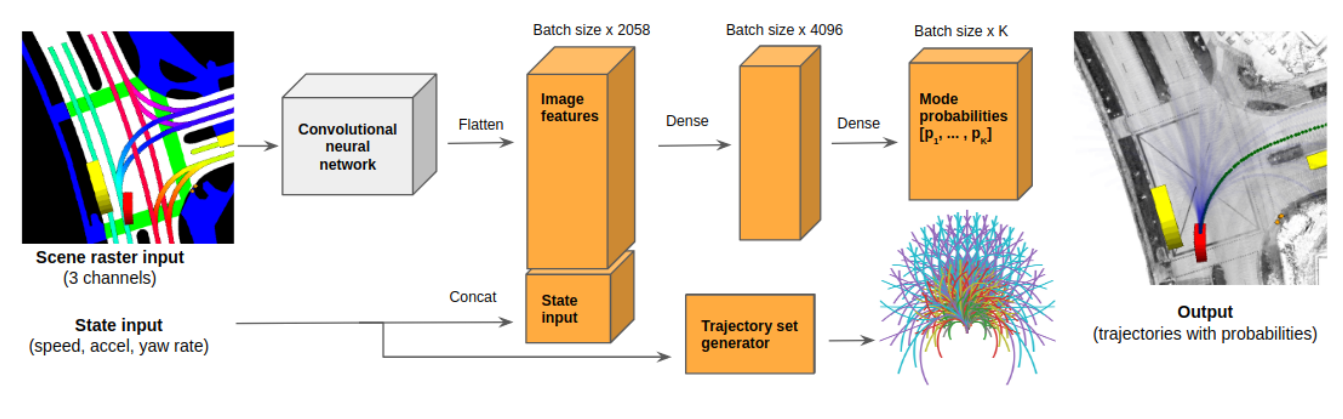


In [ ]:
class CoverNet(pl.LightningModule):
    """ CoverNet model for Trajectory Prediction """

    def __init__(self, K_size, epsilon, traj_link, traj_dir, device,
                 lr=COVERNET_LR, momentum=COVERNET_MOMENTUM,
                 traj_samples=SAMPLES_PER_SECOND*TRAJ_HORIZON):
        """ CoverNet initialization

        Parameters
        ----------
        K_size: number of modes (trajectories)
        epsilon: value (in meters) relative to the space coverage
        traj_link: link from which to download the trajectories
        device: target device of the model (e.g. "cuda:0")
        lr: learning rate of the optimizer
        momentum: momentum of the optimizer
        traj_samples: number of samples to consider in the trajectory
        """
        super().__init__()
        self.time = {}
        self.time["training"] = 0
        self.time["training:cpu"] = 0
        self.K_size = K_size
        self.convModel = resnet50(pretrained=True)
        self.activation = {}

        def get_activation(name):
            def hook(model, input, output):
                self.activation[name] = output
            return hook
        self.convModel.layer4.register_forward_hook(get_activation("layer4"))
        self.trajectories = prepare_trajectories(epsilon, traj_link, traj_dir)
        self.fc1 = nn.Linear(2051, 4096)
        self.fc2 = nn.Linear(4096, self.trajectories.size()[0])
        self.traj_samples = traj_samples
        self.tgt_device = device
        self.momentum = momentum
        self.lr = lr

    def forward(self, x) -> torch.Tensor:
        """ Network inference """
        img, state = x
        self.convModel(img)
        resnet_output = torch.flatten(self.convModel.avgpool(
            self.activation["layer4"]), start_dim=1)
        x = torch.cat([resnet_output, state], 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        """ Training step of the model

        Parameters
        ----------
        batch: batch of data
        batch_idx: index of the actual batch (from 0 to len(dataset))
        """
        # Collect data
        self.time["training"] -= time.time()
        self.time["training:cpu"] -= time.thread_time()
        x_state, _, x_img, gt, _ = batch
        x_state = torch.flatten(x_state, 0, 1)
        reduced_traj = self.trajectories[:, :self.traj_samples]
        # Prepare positive samples
        with torch.no_grad():
            y = get_positives(reduced_traj, gt.to("cpu"))
            y = y.to(self.tgt_device)
        # Inference
        y_hat = self((x_img, x_state))
        loss = F.cross_entropy(y_hat, y)
        # Log
        self.log("train_loss", loss.item(), on_step=True)

        self.time["training:cpu"] += time.thread_time()
        self.time["training"] += time.time()
        return loss

    def validation_step(self, batch, batch_idx):
        """ Validation step of the model

        Parameters
        ----------
        batch: batch of data
        batch_idx: index of the actual batch (from 0 to len(dataset))
        """
        with torch.no_grad():
            # Collect data
            x_state, _, x_img, gt, _ = batch
            x_state = torch.flatten(x_state, 0, 1)
            reduced_traj = self.trajectories[:, :self.traj_samples]
            # Prepare positive samples
            y = get_positives(reduced_traj, gt.to("cpu"))
            y = y.to(self.tgt_device)
            # Inference
            y_hat = self((x_img, x_state))
            loss = F.cross_entropy(y_hat, y)
        # Log
        self.log("val_loss", loss.item(), on_epoch=True)

        return loss

    def configure_optimizers(self):
        """ Set the optimizer for the model """
        return torch.optim.SGD(self.parameters(),
                               lr=self.lr,
                               momentum=self.momentum)


def get_positives(trajectories, ground_truth) -> torch.Tensor:
    """ Get positive samples wrt the actual GT

    Parameters
    ----------
    trajectories: the pre-generated set of trajectories
    ground_truth: the future trajectory for the agent

    Return
    ------
    positive_traj: as defined in the original CoverNet paper,
        "positive samples determined by the element in the trajectory set
        closest to the actual ground truth in minimum average
        of point-wise Euclidean distances"
    """
    euclidean_dist = torch.stack([torch.pow(torch.sub(trajectories, gt), 2)
                                  for gt in ground_truth]).sum(dim=3).sqrt()
    mean_euclidean_dist = euclidean_dist.mean(dim=2)
    positive_traj = mean_euclidean_dist.argmin(dim=1)
    return positive_traj


def prepare_trajectories(epsilon, download_link, directory) -> torch.Tensor:
    """ Function to download and extract trajectory sets for CoverNet

    Parameters
    ----------
    epsilon: value (in meters) relative to the space coverage
    download_link: link from which to download trajectory sets
    directory: directory where to download trajectory sets

    Return
    ------
    trajectories: tensor of the trajectory set for the specified epsilon
    """
    # 1. Download and extract trajectories
    filename_zip = "nuscenes-prediction-challenge-trajectory-sets.zip"
    filename = filename_zip[:-4]
    filename_dir = os.path.join(directory, filename)
    filename_zipdir = os.path.join(directory, filename_zip)
    if ((not os.path.isdir(filename_dir)
         or any(e not in os.listdir(filename_dir) for e in
                ["epsilon_2.pkl", "epsilon_4.pkl",
                 "epsilon_8.pkl"]))):
        print("Downloading trajectories ...")
        os.makedirs(directory, exist_ok=True)
        urllib.request.urlretrieve(download_link, filename_zipdir)
        with zipfile.ZipFile(filename_zipdir, "r") as archive:
            archive.extractall(directory)
        os.remove(filename_zipdir)

    # 2. Generate trajectories
    traj_set_path = os.path.join(filename_dir, "epsilon_"
                                 + str(epsilon) + ".pkl")
    trajectories = pickle.load(open(traj_set_path, "rb"))
    return torch.Tensor(trajectories)

#### **P2T**


This powerful baseline is based on two main concepts:

*   **Joint inference of goals and paths by learning rewards**: In practice this means that a Reward Model is used to achieve the Maximum Entropy Inverse Reinforcement Learning (IRL) objective, by learning the reward of a certain path with the goal and, at the same time, infer goals and paths of the specific trajectory. This is pretty useful because it overcomes the problem of the Reinforcement Learning framework that normally needs a pre-defined
absorbing goal state to work. Furthermore, the inference is lightweight because all the computation is done on a grid representation of the scene
*   **Trajectories conditioned on plans**: The resulting policy from the Maximum Entropy IRL is sampled in order to obtain plans, that are discrete waypoints on the grid representation of the scene. These waypoints are then encoded with Bidirectional GRU units and decoded with an attention mechanism, based also on the encoded past motion of the agent


The resulting architecture is the following one:


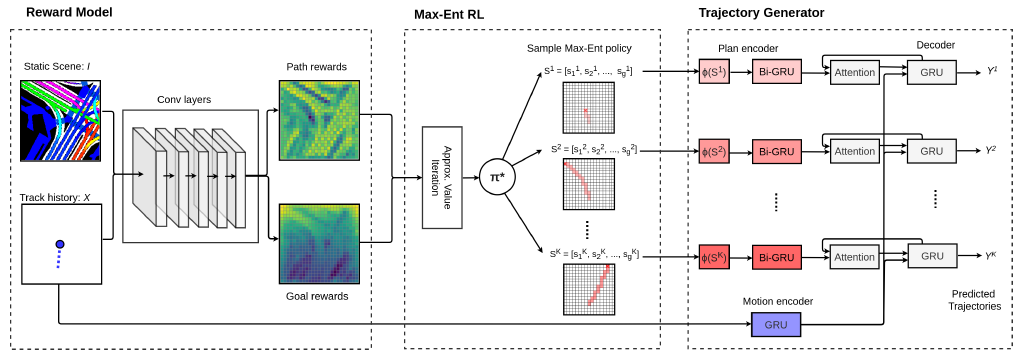



The MDP is defined as a grid-world like environment. The agent can move, as usual, in 4 directions and can decide to not move at all. A goal state is reached when the agent executes this last action. Given the reward for the moving part of the simulation and for the goal state, the max ent policy is computed via the two algorithms shown in the figure below.

**Value iteration**

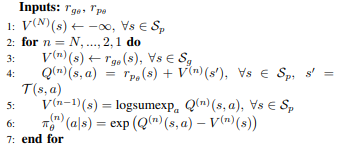

**Policy propagation**

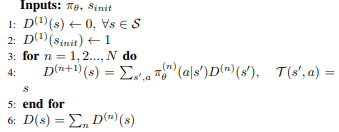

The value iteration algorithm is used to compute the Q table for the RL problem starting from the final state going backwards. After this step the max ent policy is computed for the current iteration.

The policy iteration algorithm is used to compute the state visitation frequency, i. e. the probability for the agent to land on every cell in the grid based on the current policy. This result is later compared with the ground truth as the metric used to train the reward model

In [ ]:
class MDP():
    def __init__(self, horizon, grid_dim: int, device):
        """ Markov Decision Problem class Initialization
        Adapted from the authors' implementation, using a more intelligible
        shape for the states and a closer similarity to the paper's algorithms

        Parameters
        ----------
        horizon: trjectory horizon for the problem
        grid_dim: the number of squares per side of the grid
        device: where to load tensors
        """
        self.grid_dim = grid_dim
        self.horizon = horizon
        self.tgt_device = device
        self.gamma = 0.99
        self.goal = 1
        self.path = 0
        self.action_space = torch.tensor([(1, 0), (0, 1), (-1, 0),
                                          (0, -1), (0, 0)])
        self.actions = len(self.action_space)

        self.next_states = torch.zeros((3, self.actions, 2,
                                        grid_dim, grid_dim)).long().to(
                                            self.tgt_device)
        self.next_inv = torch.zeros((self.actions, 2,
                                     grid_dim, grid_dim)).to(self.tgt_device)
        self.prev_states = torch.zeros((3, self.actions, 2,
                                        grid_dim, grid_dim)).long().to(
                                            self.tgt_device)
        self.prev_inv = torch.ones((self.actions, 2,
                                    grid_dim, grid_dim)).to(self.tgt_device)
        for a in range(self.actions):
            for t in range(2):
                for x in range(grid_dim):
                    for y in range(grid_dim):
                        next = self.transition_function(
                            torch.tensor([t, x, y]), a)
                        prev = self.transition_function(
                            torch.tensor([t, x, y]), a, True)
                        if torch.all(next == -1):
                            self.next_inv[a, t, x, y] = -math.inf
                        else:
                            self.next_states[:, a, t, x, y] = next
                        if torch.all(prev == -1):
                            self.prev_inv[a, t, x, y] = 0
                        else:
                            self.prev_states[:, a, t, x, y] = prev

        self.next_states.requires_grad = False
        self.next_inv.requires_grad = False
        self.prev_states.requires_grad = False
        self.prev_inv.requires_grad = False

    def transition_function(self, state: torch.Tensor,
                            action: int,
                            reverse: bool = False) -> torch.Tensor:
        """ transition function for MDP

        Parameters
        ----------
        state: a tuple containing information about
               the type of state and cell location
        action: an action expressed as a string
        reverse: whether if navigating the actions-states sequence backwards
        """
        if state[0] == self.goal:
            if reverse:
                if action == self.actions-1:
                    return torch.tensor([self.path, *state[1:]])
            return torch.tensor([-1, -1, -1])
        if action == self.actions-1:
            if reverse:
                return torch.tensor([-1, -1, -1])
            else:
                return torch.tensor([self.goal, *state[1:]])
        if reverse:
            new_state = state[1:]-self.action_space[action]
        else:
            new_state = state[1:]+self.action_space[action]

        if (0 <= new_state[0] < self.grid_dim
                and 0 <= new_state[1] < self.grid_dim):
            return torch.tensor([self.path, *new_state])
        else:
            return torch.tensor([-1, -1, -1])

    def value_iteration(self, r_path: torch.Tensor, r_goal: torch.Tensor):
        """ algorithm 3 from paper: computes policy based on reward

        Parameters
        ----------
        r_path: reward tensor for path states
                (shape [batch_size, 1, grid_dim, grid_dim])
        r_goal: reward tensor for goal states
                (shape [batch_size, 1, grid_dim, grid_dim])
        """
        r_path = r_path.squeeze(1)
        r_goal = r_goal.squeeze(1)
        r = torch.stack([r_path, r_goal], 1)
        v = torch.zeros_like(r)
        v[:, self.path] = -math.inf
        v[:, self.goal] = r_goal

        q = torch.zeros(
            ((v.shape[0], self.actions) + v.shape[-3:])).to(self.tgt_device)
        pi = torch.zeros(
            ((v.shape[0], self.horizon) + q.shape[-4:])).to(self.tgt_device)

        q.requires_grad = False
        pi.requires_grad = False
        v.requires_grad = False

        for n in range(self.horizon-1, -1, -1):
            q = (r.unsqueeze(1) + self.gamma *
                 v[:, self.next_states[0], self.next_states[1],
                   self.next_states[2]] + self.next_inv)
            v = torch.logsumexp(q, 1)
            v[:, self.goal] = r_goal
            pi[:, n] = torch.exp(q-v.unsqueeze(1))
        pi[torch.isnan(pi)] = 0

        self.pi = pi
        self.pi.requires_grad = False

    def policy_propagation(self, initial_state):
        """ algorithm 4 from paper: computes the
            state visitation frequency based on the current policy

        Parameters
        ----------
        initial_state: the starting block in the grid
        """
        svf_t = torch.zeros((self.pi.shape[0], self.horizon, 2,
                             self.grid_dim, self.grid_dim)).to(self.tgt_device)
        svf_t.requires_grad = False
        svf_t[:, 0, 0, initial_state[0], initial_state[1]] = 1

        a_idcs = torch.arange(self.actions).repeat(
            2, self.grid_dim, self.grid_dim, 1).permute(3, 0, 1, 2)

        for n in range(1, self.horizon):
            prev_pi = self.pi[:, n-1, a_idcs, self.prev_states[0],
                              self.prev_states[1], self.prev_states[2]]
            prev_svf = svf_t[:, n-1, self.prev_states[0],
                             self.prev_states[1], self.prev_states[2]]
            svf_t[:, n] = torch.sum(prev_pi*prev_svf*self.prev_inv, 1)

        self.svf = torch.sum(svf_t, 1)
        self.svf.requires_grad = False

    def sample_policy(self, num_samples, initial_state,
                      scene_tensor: torch.Tensor, agent_tensor: torch.Tensor,
                      centers: torch.Tensor):
        """ selects a batch of most probable policies
            based on scene and agent state

        Parameters
        ----------
        num_samples:    number of samples to choose from
        initial_state:  the starting block in the grid
        scene_tensor:   tensor containing data from the scene
        agent_tensor:   tensor containing data from the agent
        centers:        tensor to convert continuous position
                        in positions in the grid

        Return
        ------
        waypts:         sequence of blocks visited using the sampled policies
        scene_feats:    scene features extracted
        agent_feats:    agent features extracted
        """
        pi = self.pi.permute(0, 1, 3, 4, 5, 2)
        pi[:, :, 1, :, :, -1] = 1
        next_states = self.next_states.permute(0, 2, 3, 4, 1)
        next_states[:, 1, :, :, -1] = self.next_states[:, -1, 0]

        pi = pi.to(self.tgt_device)
        next_states = next_states.to(self.tgt_device)
        batch_size = pi.shape[0]
        grid_idcs = torch.zeros(batch_size * num_samples,
                                self.horizon, 2).to(self.tgt_device)
        waypts = torch.zeros_like(grid_idcs).to(self.tgt_device)
        s = torch.tensor([0, *initial_state]).unsqueeze(1).repeat(
            1, batch_size * num_samples).long().to(self.tgt_device)

        for n in range(self.horizon):
            # Populate grid_idcs and waypts
            t = s[0]
            r = s[1]
            c = s[2]
            r = r * (1 - t)
            c = c * (1 - t)

            waypts[:, n, 0] = (centers[1, r.long()] * (1 - t))
            waypts[:, n, 1] = (centers[0, c.long()] * (1 - t))
            grid_idcs[:, n, 0] = r
            grid_idcs[:, n, 1] = c

            # Sample next actions
            idcs = torch.tensor(range(batch_size)).unsqueeze(0).repeat(
                num_samples, 1).permute(1, 0).reshape(-1).to(self.tgt_device)
            pi_s = pi[idcs, n, s[0], s[1], s[2]]
            a = Categorical(pi_s).sample()

            # Obtain next states
            s = next_states[:, s[0], s[1], s[2], a]

        scene_tensor = scene_tensor.unsqueeze(0).repeat(
            num_samples, 1, 1, 1, 1).permute(1, 0, 2, 3, 4)
        scene_tensor = scene_tensor.reshape(-1, scene_tensor.shape[2],
                                            scene_tensor.shape[3],
                                            scene_tensor.shape[4])
        agent_tensor = agent_tensor.unsqueeze(0).repeat(
            num_samples, 1, 1, 1, 1).permute(1, 0, 2, 3, 4)
        agent_tensor = agent_tensor.reshape(-1, agent_tensor.shape[2],
                                            agent_tensor.shape[3],
                                            agent_tensor.shape[4])
        scene_feats, agent_feats = nuScenesAdvanced.extract_plan_features(
            grid_idcs, scene_tensor, agent_tensor)
        scene_feats = scene_feats.reshape(
            batch_size, num_samples, self.horizon, scene_feats.shape[2])
        agent_feats = agent_feats.reshape(
            batch_size, num_samples, self.horizon, agent_feats.shape[2])
        waypts = waypts.reshape(batch_size, num_samples, self.horizon, 2)

        return waypts, scene_feats, agent_feats

The reward used to compute the policy for the RL problem is divided in two cases, one for when the agent is moving (path reward) and one for the agent last state (goal reward). Both of these rewards are computed using a CNN.
As shown in the figure below, the two reward networks share a first convolutional layer (the first two layers of a resnet34 pretrained on imageNet followed by a convolutional layer to reduce the output size) used as a feature extractor. The agent state velocity is concatenated to this first output. Finally, the two rewards are obtained using a sequence of two identical convolutional layers, with final depth = 1 in order to have a single image for each reward

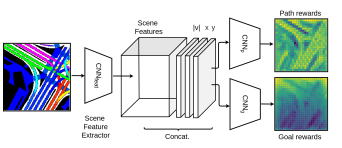

In [ ]:
class RewardModel(nn.Module):
    """ Model to extract rewards for Max-Ent RL"""

    def __init__(self, mdp: MDP):
        """ Reward model initialization

        Parameters
        ----------
        mdp: the Markov decision problem instance that belongs to the model
        """
        super().__init__()

        backbone = resnet34(pretrained=True)
        self.log_sig = nn.LogSigmoid()
        self.cnn_feat = nn.Sequential(backbone.conv1, backbone.bn1,
                                      backbone.relu, backbone.maxpool,
                                      backbone.layer1)
        self.conv1 = nn.Conv2d(in_channels=64, out_channels=32,
                               kernel_size=2, stride=2)
        self.cnn_1 = nn.Conv2d(in_channels=32+3, out_channels=32,
                               kernel_size=1)

        # not used, but necessary for compatibility with checkpoint
        self.cnn_2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=1)

        self.cnn_out = nn.Conv2d(in_channels=32, out_channels=1,
                                 kernel_size=1)

        self.cnn_p = nn.Sequential(self.cnn_1, self.cnn_out)
        self.cnn_g = copy.deepcopy(self.cnn_p)

        self.y = (torch.linspace(40 - 50/(25*2), -10 + 50/(25*2), 25).
                  reshape(-1, 1).repeat_interleave(25, 1))
        self.x = (torch.linspace(-25 + 50/(25*2), 25 - 50/(25*2), 25).
                  reshape(-1, 1).repeat_interleave(25, 1).transpose(0, 1))
        self.motion_feats = torch.zeros((3, 25, 25))

        self.mdp = mdp
        self.initial_state = np.random.randint(25, size=2)
        self.loss = 0
        self.activation = {}

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """ Network inference

        Parameters
        ----------
        x: the input tensor (raster image)

        Return
        ------
        r_path: computed reward for path states
        r_goal: computed reward for goal states
        img_feats: intermediate result (features extracted from the image)
        """
        img = x
        motion_feats = self.motion_feats

        img_feats = self.cnn_feat(img)
        img_feats = self.conv1(img_feats)

        x = torch.cat([img_feats, motion_feats], 1)
        r_path = self.log_sig(self.cnn_p(x))
        r_goal = self.log_sig(self.cnn_g(x))
        return r_path, r_goal, img_feats

    def get_activation(self, name):
        """ Obtain intermediate layer output from the model

        Parameters
        ----------
        name: the name of the layer to extract

        Return
        ------
        hook: function to be used to extract the layer's output
        """
        def hook(model, input, output):
            self.activation[name] = output.detach().cpu()
        return hook

Here we have the Trajectory Generator class. The implementation choices regarding this class are all based on the principles of modularity and readability. While in the original code there is no distincion between the different parts of the Trajectory Generator (they are all layers set as members of the Trajectory Generator class), here all the components have a own identity, leading to a very clean code and a more understandable behaviour of the complete class. In fact, we defined:


*   **`Trajectory Generator`** -> main class
*   **`Motion Encoder`** -> component class to encode the past motion of the agent
*   **`Plan Encoder`** -> component class to encode the plans sampled from the Maximum Entropy IRL policy
*   **`Attention Decoder`** -> component class to decode the trajectory with an attention-based mechanism



In [ ]:
class Trajectory_Generator(nn.Module):
    """ Trajectory Generator class """

    def __init__(self, traj_device,
                 traj_hidden_size=TRAJ_HIDDEN_SIZE,
                 plan_hidden_size=PLAN_HIDDEN_SIZE,
                 att_hidden_size=ATT_HIDDEN_SIZE,
                 pos_embedding_size=POS_EMBEDDING_SIZE,
                 scene_embedding_size=SCENE_EMBEDDING_SIZE,
                 agent_embedding_size=AGENT_EMBEDDING_SIZE,
                 scene_features_size=SCENE_FEATURES_SIZE,
                 agent_features_size=AGENT_FEATURES_SIZE,
                 dyn_features_size=DYN_FEATURES_SIZE,
                 slope=ACTIVATION_SLOPE,
                 traj_samples=SAMPLES_PER_SECOND*TRAJ_HORIZON):
        """ Trajectory Generator initialization

        Parameters
        ----------
        traj_device: device of the trajectory tensor in the attention decoder
        traj_hidden_size: size of the hidden layer of the
                          GRU trajectory encoder/decoder
        plan_hidden_size: size of the hidden layer of the GRU plan encoder
        att_hidden_size: size of the hidden layer of
                         the attention part in the final decoder
        pos_embedding_size: size of the linear layer for the position embedding
        scene_embedding_size: size of the linear layer for the scene embedding
        agent_embedding_size: size of the linear layer for the agent embedding
        scene_features_size: size of the scene features at each grid location
        agent_features_size: size of the agent features at each grid location
        dynamic_features_size: additional motion features to
                               add to the embedding layer
            0 -> x, y
            1 -> x, y, velocity
            2 -> x, y, velocity, acceleration
            3 -> x, y, velocity, acceleration, yaw rate
        slope: slope (positive or negative) of the activation function
        traj_samples: number of samples to consider in the trajectory
        """
        super(Trajectory_Generator, self).__init__()
        self.scene_feat_size = scene_features_size
        self.agent_feat_size = agent_features_size
        # ------------------------------------------------------------------- #
        # --------------------| Generator Structure |------------------------ #
        # ------------------------------------------------------------------- #
        self.motion_encoder = MotionEncoder(
            traj_hidden_size, pos_embedding_size, dyn_features_size, slope)
        self.plan_encoder = PlanEncoder(plan_hidden_size, pos_embedding_size,
                                        scene_embedding_size,
                                        agent_embedding_size,
                                        scene_features_size,
                                        agent_features_size, slope)
        self.att_decoder = AttentionDecoder(traj_device, att_hidden_size,
                                            traj_hidden_size,
                                            plan_hidden_size, traj_samples)
        # ------------------------------------------------------------------- #

    def forward(self, hist_motion, plan, scene_feats, agent_feats):
        """ Trajectory Generator inference
        Input:
            - hist_motion: history motion tensor
            - plan: tensor of waypoints
            - scene_feats: scene features
            - agent_feats: agent features
        Output: trajectory -> decoded trajectory tensor
        """
        enc_motion = self.motion_encoder(hist_motion)
        enc_plan = self.plan_encoder(plan, scene_feats, agent_feats)
        trajectory = self.att_decoder(hist_motion, enc_motion, enc_plan)
        return trajectory


class MotionEncoder(nn.Module):
    """ Motion Encoder class for Trajectory Generator """

    def __init__(self, traj_hidden_size, pos_embedding_size,
                 dyn_features_size, slope=ACTIVATION_SLOPE):
        """ Motion Encoder initialization

        Parameters
        ----------
        traj_hidden_size: size of the hidden layer of the
                          GRU trajectory encoder/decoder
        plan_hidden_size: size of the hidden layer of the GRU plan encoder
        pos_embedding_size: size of the linear layer for the
                            position embedding (x-y)
        dyn_features_size: additional motion features to add to the
                           embedding layer
            0 -> x, y
            1 -> x, y, velocity
            2 -> x, y, velocity, acceleration
            3 -> x, y, velocity, acceleration, yaw rate
        slope: slope (positive or negative) of the activation function
        """
        super(MotionEncoder, self).__init__()
        self.embedding = nn.Linear(2+dyn_features_size, pos_embedding_size)
        self.activation = nn.LeakyReLU(slope)
        self.encoder = nn.GRU(pos_embedding_size, traj_hidden_size)

    def forward(self, hist_motion) -> torch.Tensor:
        """ Motion Encoder inference

        Input: hist_motion -> history motion tensor
        Output: enc_motion -> encoded motion tensor
        """
        emb_features = self.activation(self.embedding(hist_motion))
        output, enc_motion = self.encoder(emb_features)
        return enc_motion


class PlanEncoder(nn.Module):
    """ Plan Encoder class for Trajectory Generator """

    def __init__(self, plan_hidden_size, pos_embedding_size,
                 scene_embedding_size, agent_embedding_size,
                 scene_features_size, agent_features_size,
                 slope=ACTIVATION_SLOPE):
        """ Plan Encoder initialization

        Parameters
        ----------
        plan_hidden_size: size of the hidden layer of the GRU plan encoder
        pos_embedding_size: size of the linear layer
                            for the position embedding
        scene_embedding_size: size of the linear layer for the scene embedding
        agent_embedding_size: size of the linear layer for the agent embedding
        scene_features_size: size of the scene features at each grid location
        agent_features_size: size of the agent features at each grid location
        slope: slope (positive or negative) of the activation function
        """
        super(PlanEncoder, self).__init__()
        self.pos_embedding = nn.Linear(2, pos_embedding_size)
        self.scene_embedding = nn.Linear(
            scene_features_size, scene_embedding_size)
        self.agent_embedding = nn.Linear(
            agent_features_size, agent_embedding_size)
        self.activation = nn.LeakyReLU(slope)
        self.encoder = nn.GRU(pos_embedding_size + scene_embedding_size
                              + agent_embedding_size, plan_hidden_size,
                              bidirectional=True)

    def forward(self, plan, scene_feats, agent_feats) -> torch.Tensor:
        """ Plan Encoder inference
        Input:
            - plan: tensor of waypoints
            - scene_feats: scene features
            - agent_feats: agent features
        Output: enc_plan -> encoded plan tensot
        """
        # Embedding
        emb_features = self.activation(
            torch.cat((self.pos_embedding(plan),
                       self.scene_embedding(scene_feats),
                       self.agent_embedding(agent_feats)), dim=2))
        # Reorganizing plans
        plan_sum = torch.sum(torch.abs(plan), dim=2)
        plan_lengths = torch.sum(plan_sum[1:, :] != 0, dim=0) + 1
        plan_lengths_sorted, indices = torch.sort(
            plan_lengths, descending=True)
        # Reorganizing embeddings
        emb_packed = (
            nn.utils.rnn.pack_padded_sequence(emb_features[:, indices, :],
                                              plan_lengths_sorted.cpu(),
                                              batch_first=False))
        # Encoding
        enc_plan_packed, output = self.encoder(emb_packed)
        enc_plan_unpacked, _ = nn.utils.rnn.pad_packed_sequence(
            enc_plan_packed)
        enc_plan = enc_plan_unpacked[:, indices.sort()[1], :]
        return enc_plan


class AttentionDecoder(nn.Module):
    """ Attention Decoder class for Trajectory Generator """

    def __init__(self, traj_device,
                 att_hidden_size,
                 traj_hidden_size,
                 plan_hidden_size,
                 traj_samples=SAMPLES_PER_SECOND*TRAJ_HORIZON):
        """ Attention Decoder initialization

        Parameters
        ----------
        traj_device: device of the trajectory tensor
        att_hidden_size: size of the hidden layer of the
                         attention part in the final decoder
        traj_hidden_size: size of the hidden layer of the
                          GRU trajectory encoder/decoder
        plan_hidden_size: size of the hidden layer of the GRU plan encoder
        traj_samples: number of samples to consider in the trajectory
        """
        super(AttentionDecoder, self).__init__()
        self.traj_device = traj_device
        self.traj_samples = traj_samples
        self.attention = nn.Sequential(nn.Linear(2 * plan_hidden_size
                                                 + traj_hidden_size,
                                                 att_hidden_size),
                                       nn.Tanh(),
                                       nn.Linear(att_hidden_size, 1),
                                       nn.Softmax(dim=0))
        self.dec_state_op = nn.Linear(traj_hidden_size, 2)
        self.decoder = nn.GRUCell(2*plan_hidden_size, traj_hidden_size)

    def forward(self, hist_motion, enc_motion, enc_plan) -> torch.Tensor:
        """ Attention Decoder inference

        Input:
            - hist_motion: history motion tensor
            - enc_motion: encoded motion tensor
            - enc_plan: encoded plan tensor
        Output: dec_traj -> decoded trajectory tensor
        """
        # Initialization
        dec_traj = torch.empty((self.traj_samples,
                                hist_motion.shape[1],
                                2),
                               dtype=torch.float32).to(self.traj_device)
        motion = enc_motion.squeeze()
        # Attention loop
        for s in range(self.traj_samples):
            att_input = torch.cat(
                (motion.repeat(enc_plan.shape[0], 1, 1), enc_plan), dim=2)
            att_features = self.attention(att_input)
            dec_input = (att_features.repeat(
                1, 1, enc_plan.shape[2])*enc_plan).sum(dim=0)
            motion = self.decoder(dec_input, motion)
            dec_traj[s] = self.dec_state_op(motion)
        return dec_traj.permute(1, 0, 2)


# NOTE: the presence of no clusters can be handled with np.inf
class TrajGenLoss(nn.Module):
    """ Loss for the Trajectory Generator training """
    def __init__(self, phase="train", loss_fun=None):
        """ Trajectory Generator loss initialization

        Parameters
        ----------
        phase: "pretrain" or "train"
        loss_fun: function to compute loss; available ["min_ade_k"]
        """
        super(TrajGenLoss, self).__init__()
        if phase == "pretrain":
            self.loss_fun = nn.MSELoss()
            if loss_fun is not None:
                warnings.warn("In pretrain phase only MSELoss is available")
        elif loss_fun is None or loss_fun == "min_ade_k":
            self.loss_fun = self.min_ade_k
        else:
            raise ValueError(("Wrong argument loss_fun: "
                              + "available 'None' or 'min_ade_k'"))

    def min_ade_k(self, pred, gt):
        """ Min_Ade_K loss for the Trajectory Generator

        Parameters
        ----------
        pred: clustered trajectories predicted
        gt: ground truth

        Return
        ------
        min_ade: mean over the batch of the min ade loss
        """
        diff = torch.sub(gt.unsqueeze(1), pred)
        norm = torch.sqrt(torch.sum(diff ** 2, 3))
        ade = torch.mean(norm, 2)
        min_ade, _ = torch.min(ade, 1)
        return min_ade.mean()

    def forward(self, x, y):
        """ Trajectory Generator loss computation """
        return self.loss_fun(x, y)

The following one is the all-in-one class of the implemented baseline. While in the original paper all the code relative to train of the various models, inference and other stuff is handled in different files, here we have defined a single class that encapsulate all the models and all the related functions, from training to validation to data preparation. In this way, we have obtained a considerable saving of code and space, furthermore the code is more clean and readable, so the user can immediately understand all the core parts of this framework and the structure of the P2T baseline. The following features are available for this class:


*   **Complete Network Inference**
*   **Reward Model** training and validation
*   **Trajectory Generator** pre-training, finetuning and validation
*   **Checkpoints** saving and loading
*   **Logging** for network results 
*   **Data** supplementary preparation 

Obviously, since this class contains the nucleus of the P2T working, some snipped of code are similar to the original implementation; an example is the *forward* function, in which we can find an analogous structure with respect to the one of the paper's authors. Anyway, where the code would have been improved both in readability and efficiency, we have surely acted on it.

N.B: the code related to the KMeans clustering in the *forward* function has been converted from multiprocessing to single-process, for inefficiency and memory reasons



In [ ]:
class P2T(nn.Module):
    """ P2T Model for trajectory prediction """

    def __init__(self, mdp: MDP, device, centers,
                 initial_state=INITIAL_STATE, policy_samples=POLICY_SAMPLES,
                 traj_clusters=TRAJ_CLUSTERS, from_checkpoint=[],
                 checkpoint_period=CHECKPOINT_PERIOD,
                 checkpoint_dir=CHECKPOINT_DIR,
                 checkpoint_method=CHECKPOINT_METHOD,
                 print_period=PRINT_PERIOD,
                 pretrain_traj_gen=True, train_rm_epoches=TRAIN_RM_EPOCHES,
                 pretrain_tg_epoches=PRETRAIN_TG_EPOCHES,
                 train_tg_epoches=TRAIN_TG_EPOCHES,
                 reward_model_lr=REWARD_MODEL_LR,
                 traj_gen_lr_pre=TRAJ_GEN_LR_PRE, traj_gen_lr=TRAJ_GEN_LR,
                 rm_logname=RM_LOGNAME, pre_tg_logname=PRE_TG_LOGNAME,
                 ft_tg_logname=FT_TG_LOGNAME, max_norm=MAX_CLIP_NORM,
                 horizon_folder=HORIZON_FOLDER):
        """ P2T Model initialization

        Parameters
        ----------
        mdp: Markov Decision Process class instance
        device: device of execution [e.g. CUDA:0]
        centers: row centers and column centers, needed for the inference
        initial_state: initial state of the agent
        policy_samples: how many samples to extract from the policy
        traj_clusters: num of trajectory clusters
        from_checkpoint: options -> [], ["rm"], ["rm", "tg_pre"], ["rm", "tg"]
        checkpoint_period: saving checkpoints period
        checkpoint_dir: directory to save checkpoints
        checkpoint_method: method for checkpoint saving (e.g. "last", "best")
        print_period: print loss values period
        pretrain_traj_gen: True if to pretrain the Trajectory Generator
        train_rm_epoches: # epoches to train the Reward Model
        pretrain_tg_epoches: # epoches to train the Trajectory Generator (pre)
        train_tg_epoches: # epoches to train the Trajectory Generator (ft)
        reward_model_lr: learning rate of the Reward Model
        traj_gen_lr_pre: learning rate of the Trajectory Generator (pre-train)
        traj_gen_lr: learning rate of the Trajectory Generator (fine-tune)
        rm_logname: SummaryWriter comment related to reward model
        pre_tg_logname: SummaryWriter comment related to traj generator (pre)
        ft_tg_logname: SummaryWriter comment related to traj generator (ft)
        max_norm: maximum norm to clip gradients
        horizon_folder: (convenience parameter) horizon folder for checkpoints
        """
        # Basic initialization
        super(P2T, self).__init__()
        self.time = {}
        self.time["training"] = 0
        self.time["training:cpu"] = 0
        self.time["training:reward_model"] = 0
        self.time["training:pre_traj_generator"] = 0
        self.time["training:traj_generator"] = 0
        self.mdp = mdp
        self.tgt_device = device
        self.initial_state = initial_state
        self.policy_samples = policy_samples
        self.from_checkpoint = from_checkpoint
        self.traj_clusters = traj_clusters
        self.checkpoint_period = checkpoint_period
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_method = checkpoint_method
        self.print_period = print_period
        self.rm_logger = SummaryWriter(comment=f"_{rm_logname}")
        self.pre_tg_logger = SummaryWriter(comment=f"_{pre_tg_logname}")
        self.ft_tg_logger = SummaryWriter(comment=f"_{ft_tg_logname}")
        self.pretrain_traj_gen = pretrain_traj_gen
        self.pretrain_tg_epoches = pretrain_tg_epoches
        self.train_rm_epoches = train_rm_epoches
        self.train_tg_epoches = train_tg_epoches
        self.reward_model_lr = reward_model_lr
        self.traj_gen_lr_pre = traj_gen_lr_pre
        self.traj_gen_lr = traj_gen_lr
        self.max_norm = max_norm

        # Model initialization
        self.reward_model = RewardModel(mdp).to(device)
        self.traj_generator = Trajectory_Generator(device).to(device)

        # Convenience initialization
        self.centers = centers.to(self.tgt_device)
        self.horizon_folder = horizon_folder

        # Checkpoint loading
        self.rm_checkpoint = None
        self.tg_checkpoint = None
        self.from_checkpoint = from_checkpoint
        if "rm" in from_checkpoint:
            print("Reward Model checkpoint loading ...")
            checkpoint_path = os.path.join(self.checkpoint_dir, "P2T",
                                           self.horizon_folder, "reward_model")
            self.rm_checkpoint = self.select_checkpoint(checkpoint_path,
                                                        checkpoint_method)
            if self.rm_checkpoint is not None:
                self.reward_model.load_state_dict(
                    self.rm_checkpoint["reward_model_state"])
                print("Reward Model checkpoint loaded from epoch",
                      self.rm_checkpoint["epoch"], "with loss",
                      self.rm_checkpoint["loss"])
        if "tg_pre" in from_checkpoint or "tg" in from_checkpoint:
            print("Trajectory Generator checkpoint loading ...")
            if "tg_pre" in from_checkpoint:
                checkpoint_path = os.path.join(self.checkpoint_dir, "P2T",
                                               self.horizon_folder,
                                               "traj_generator", "pretrain")
            else:
                checkpoint_path = os.path.join(self.checkpoint_dir, "P2T",
                                               self.horizon_folder,
                                               "traj_generator", "finetune")
            self.tg_checkpoint = self.select_checkpoint(
                checkpoint_path, checkpoint_method)
            if self.tg_checkpoint is not None:
                self.traj_generator.load_state_dict(
                    self.tg_checkpoint["traj_generator_state"])
                print("Trajectory Generator checkpoint loaded from epoch",
                      self.tg_checkpoint["epoch"], "with loss",
                      self.tg_checkpoint["loss"])

    def train(self, trainval_dm: nuScenesDataModule):
        """ P2T function for training all components

        Parameters
        ----------
        trainval_dm: PyTorch Lightning datamodule containing trainval data
        """
        # Train initialization
        self.horizon_folder = trainval_dm.train_dataset.horizon_folder

        # Train starting
        print("Starting P2T training")
        start = time.time()
        self.time["training"] -= time.time()
        self.time["training:cpu"] -= time.thread_time()
        self.train_reward_model(trainval_dm)
        self.train_traj_generator(trainval_dm)
        self.time["training"] += time.time()
        self.time["training:cpu"] += time.thread_time()
        print("P2T Model trained in %f s" % (time.time() - start))

    def train_reward_model(self, trainval_dm: nuScenesDataModule):
        """ Reward Model training

        Parameters
        ----------
        trainval_dm: PyTorch Lightning datamodule containing trainval data
        """
        print("Starting P2T Reward Model training")
        start = time.time()
        optimizer = torch.optim.Adam(
            self.reward_model.parameters(), lr=self.reward_model_lr)
        train_dataloader = trainval_dm.train_dataloader()
        val_dataloader = trainval_dm.val_dataloader()
        start_epoch = 0

        if self.rm_checkpoint is not None:
            print("Reward Model optimizer checkpoint loading ...")
            optimizer.load_state_dict(self.rm_checkpoint["optimizer_state"])
            start_epoch = self.rm_checkpoint["epoch"] + 1
        if ((start_epoch == self.train_rm_epoches)
            or ((self.checkpoint_method == "best")
                and len(self.from_checkpoint) > 1)):
            print("Reward Model has already been trained completely")
            return

        with tqdm(total=len(train_dataloader), position=0, leave=True) as pbar:
            for e in range(start_epoch, self.train_rm_epoches):
                pbar.reset(len(train_dataloader))
                pbar.set_description(f"[RM] Epoch {e} - training")

                self.time["training:reward_model"] -= time.time()

                # Train
                self.reward_model.train()
                train_iter = iter(train_dataloader)
                (_, next_x_img_static, _, _, _, _, _, next_svf_e,
                 _, _, next_motion_feats) = train_iter.next()
                pbar.update(1)
                next_svf_e = next_svf_e.float().to(self.tgt_device,
                                                   non_blocking=True)
                next_x_img_static = next_x_img_static.float().to(
                    self.tgt_device, non_blocking=True)
                next_motion_feats = next_motion_feats.float().to(
                    self.tgt_device, non_blocking=True)
                for b, data in enumerate(train_dataloader, start=1):
                    svf_e = next_svf_e
                    x_img_static = next_x_img_static
                    motion_feats = next_motion_feats
                    if b < len(train_dataloader):
                        (_, next_x_img_static, _, _, _, _, _,
                         next_svf_e, _, _, next_motion_feats) = data
                        next_svf_e = next_svf_e.float().to(self.tgt_device,
                                                           non_blocking=True)
                        next_x_img_static = next_x_img_static.float().to(
                            self.tgt_device, non_blocking=True)
                        next_motion_feats = next_motion_feats.float().to(
                            self.tgt_device, non_blocking=True)

                    self.reward_model.motion_feats = motion_feats
                    r_path, r_goal, _ = self.reward_model(x_img_static)
                    self.mdp.value_iteration(r_path.detach(), r_goal.detach())
                    self.mdp.policy_propagation(self.initial_state)
                    svf = self.mdp.svf.to(self.tgt_device)
                    svf_grad = svf - svf_e

                    optimizer.zero_grad()
                    torch.autograd.backward(
                        torch.cat([r_path, r_goal], 1), svf_grad)
                    a = torch.nn.utils.clip_grad_norm_(
                        self.reward_model.parameters(), self.max_norm)
                    optimizer.step()

                    iterations = e*len(train_dataloader) + b

                    # Logging
                    if b % 100 == 0:
                        plt.ioff()

                        f, a = plt.subplots(8, 7, figsize=(20, 20))
                        a[0, 0].set_title("original image", fontsize=16)
                        a[0, 1].set_title("path reward", fontsize=16)
                        a[0, 2].set_title("goal reward", fontsize=16)
                        a[0, 3].set_title("learned path svf", fontsize=16)
                        a[0, 4].set_title("learned goal svf", fontsize=16)
                        a[0, 5].set_title("true path svf", fontsize=16)
                        a[0, 6].set_title("true goal svf", fontsize=16)
                        for i in range(8):
                            a[i, 0].imshow(torch.clip(x_img_static[i]
                                                      .detach().cpu()
                                                      .permute(1, 2, 0), 0, 1))
                            a[i, 1].imshow(r_path[i].squeeze(1)
                                           .detach().cpu(), cmap="viridis")
                            a[i, 2].imshow(r_goal[i].squeeze(1)
                                           .detach().cpu(), cmap="viridis")
                            a[i, 3].imshow(svf[i, 0]
                                           .detach().cpu(), cmap="viridis")
                            a[i, 4].imshow(svf[i, 1]
                                           .detach().cpu(), cmap="viridis")
                            a[i, 5].imshow(svf_e[i, 0]
                                           .detach().cpu(), cmap="viridis")
                            a[i, 6].imshow(svf_e[i, 1]
                                           .detach().cpu(), cmap="viridis")

                        self.rm_logger.add_figure(
                            "rewawd model overview", f, iterations)

                        plt.ion()

                    self.rm_logger.add_scalar("svf grad path", torch.mean(
                        torch.abs(svf_grad[:, 0])).item(), iterations)
                    self.rm_logger.add_scalar("svf grad goal", torch.mean(
                        torch.abs(svf_grad[:, 1])).item(), iterations)
                    # tqdm bar update
                    svf_grad_path_print = (
                        torch.mean(torch.abs(svf_grad[:, 0])).item())
                    svf_grad_goal_print = (
                        torch.mean(torch.abs(svf_grad[:, 1])).item())
                    pbar_desc = (f"[RM] Epoch {e} - training - svf grad path ="
                                 + f" {svf_grad_path_print:.2E}, "
                                 + "svf grad goal = "
                                 + f"{svf_grad_goal_print:.2E}")
                    pbar.set_description(pbar_desc)
                    pbar.update(1)

                self.time["training:reward_model"] += time.time()

                # Val
                val_losses = []
                self.reward_model.eval()
                with torch.no_grad():
                    svf_grad_path_sum = 0
                    svf_grad_goal_sum = 0
                    val_batch_count = 0

                    pbar.reset(len(val_dataloader))
                    pbar.set_description(f"[RM] Epoch {e} - validation")

                    for b, data in enumerate(val_dataloader):
                        (_, x_img_static, _, _, _, _, _,
                         svf_e, _, _, motion_feats) = data
                        svf_e = svf_e.float().to(self.tgt_device)
                        x_img_static = x_img_static.float().to(self.tgt_device)
                        motion_feats = motion_feats.float().to(self.tgt_device)

                        self.reward_model.motion_feats = motion_feats

                        r_path, r_goal, _ = self.reward_model(x_img_static)

                        self.mdp.value_iteration(
                            r_path.detach(), r_goal.detach())
                        self.mdp.policy_propagation(self.initial_state)

                        svf = self.mdp.svf.to(self.tgt_device)

                        svf_grad = svf - svf_e

                        svf_grad_path_sum += torch.mean(
                            torch.abs(svf_grad[:, 0])).item()
                        svf_grad_goal_sum += torch.mean(
                            torch.abs(svf_grad[:, 1])).item()
                        val_batch_count += 1

                        val_loss = svf_grad_path_sum / val_batch_count
                        val_losses.append(val_loss)

                        # tqdm bar update
                        pbar.set_description((f"[RM] Epoch {e} - validation - "
                                              + f"val loss = {val_loss:.2E}"))
                        pbar.update(1)

                    mean_loss = np.array(val_losses).mean()
                    self.rm_logger.add_scalar("val loss", mean_loss, e)

                    # Save weights
                    if (e+1) % self.checkpoint_period == 0:
                        print("Saving weights ...")
                        torch.save({"epoch": e,
                                    "reward_model_state":
                                        self.reward_model.state_dict(),
                                    "optimizer_state": optimizer.state_dict(),
                                    "loss": mean_loss},
                                   os.path.join(self.checkpoint_dir,
                                                "P2T", self.horizon_folder,
                                                "reward_model", f"{e}.pt"))
                print(f"[RM] val loss for epoch {e} = {mean_loss}")

        self.rm_logger.close()
        print("Reward Model trained in %f s" % (time.time() - start))

    @ignore_warnings(category=ConvergenceWarning)
    def train_traj_generator(self, trainval_dm: nuScenesDataModule):
        """ Trajectory Generator training

        Parameters
        ----------
        trainval_dm: PyTorch Lightning datamodule containing trainval data
        """
        # Training initialization
        print("Starting P2T Trajectory Generator training")
        start = time.time()
        self.reward_model.eval()
        loss = TrajGenLoss("train")
        optimizer = torch.optim.Adam(
            self.traj_generator.parameters(), lr=self.traj_gen_lr)
        train_dataloader = trainval_dm.train_dataloader()
        val_dataloader = trainval_dm.val_dataloader()
        batches_train = len(train_dataloader)
        batches_val = len(val_dataloader)
        start_epoch = 0

        # Trajectory Generator pre-training
        if self.pretrain_traj_gen:
            self.pretrain_traj_generator(trainval_dm)

        # Checkpoint loading
        if self.tg_checkpoint is not None and "tg" in self.from_checkpoint:
            print("Trajectory Generator optimizer checkpoint loading ...")
            optimizer.load_state_dict(self.tg_checkpoint["optimizer_state"])
            start_epoch = self.tg_checkpoint["epoch"] + 1
        if start_epoch == self.pretrain_tg_epoches:
            print("Trajectory Generator has already been trained completely")
            return

        # Training Loop
        with tqdm(total=len(train_dataloader), position=0, leave=True) as pbar:
            for e in range(start_epoch, self.train_tg_epoches):
                pbar.reset(len(train_dataloader))
                pbar.set_description(f"[TG] Epoch {e} - training")
                self.time["training:traj_generator"] -= time.time()

                # Train
                self.traj_generator.train()
                # extract and pass next batch to device (preload trick)
                train_iter = iter(train_dataloader)
                data = train_iter.next()
                next_data = self.traj_data_preparation(data, self.tgt_device)
                pbar.update(1)
                for b, data in enumerate(train_dataloader, start=1):

                    # Data preparation
                    (x_img_static, gt, past,
                     motion_feats, _, agents, _) = next_data
                    if b < len(train_dataloader):
                        next_data = self.traj_data_preparation(
                            data, self.tgt_device)
                    model_input = (x_img_static, past, motion_feats, agents)

                    # Inference
                    traj_clust, _ = self(model_input)

                    # Learning
                    batch_loss = loss(traj_clust, gt)
                    optimizer.zero_grad()
                    batch_loss.backward()
                    a = torch.nn.utils.clip_grad_norm_(
                        self.traj_generator.parameters(), self.max_norm)
                    optimizer.step()

                    # Logging
                    loss_val = batch_loss.item()
                    iterations = e*len(train_dataloader) + b
                    self.ft_tg_logger.add_scalar(
                        "train loss", loss_val, iterations)

                    # tqdm bar update
                    pbar_desc = (f"[TG] Epoch {e} - training - "
                                 + f"train loss = {loss_val:.3E}")
                    pbar.set_description(pbar_desc)
                    pbar.update(1)

                self.time["training:traj_generator"] += time.time()

                # Val
                val_losses = []
                self.traj_generator.eval()
                with torch.no_grad():
                    pbar.reset(len(val_dataloader))
                    pbar.set_description(f"[TG] Epoch {e} - validation")
                    for b, data in enumerate(val_dataloader):

                        # Data preparation
                        (x_img_static, gt, past, motion_feats, _, agents,
                         _) = self.traj_data_preparation(data, self.tgt_device)
                        model_input = (x_img_static, past,
                                       motion_feats, agents)

                        # Inference
                        traj_clust, _ = self(model_input)

                        # Logging
                        loss_val = loss(traj_clust, gt).item()
                        val_losses.append(loss_val)
                        # tqdm bar updating
                        pbar.set_description((f"[TG] Epoch {e} - validation - "
                                              + f"val loss = {loss_val:.3E}"))
                        pbar.update(1)

                # Validation logging
                mean_loss = np.array(val_losses).mean()
                self.ft_tg_logger.add_scalar("val loss", mean_loss, e)

                # Save weights
                if (e+1) % self.checkpoint_period == 0:
                    print("Saving weights ...")
                    torch.save({"epoch": e,
                                "traj_generator_state":
                                    self.traj_generator.state_dict(),
                                "optimizer_state": optimizer.state_dict(),
                                "loss": mean_loss},
                               os.path.join(self.checkpoint_dir, "P2T",
                                            self.horizon_folder,
                                            "traj_generator", "finetune",
                                            str(e) + ".pt"))

        self.ft_tg_logger.close()
        print("Trajectory Generator trained in %f s" % (time.time() - start))

    def pretrain_traj_generator(self, trainval_dm: nuScenesDataModule):
        """ Trajectory Generator pre-training

        Parameters
        ----------
        trainval_dm: PyTorch Lightning datamodule containing trainval data
        """
        # Training initialization
        print("Starting P2T Trajectory Generator pre-training")
        start = time.time()
        loss = TrajGenLoss("pretrain")
        optimizer = torch.optim.Adam(
            self.traj_generator.parameters(), lr=self.traj_gen_lr_pre)
        train_dataloader = trainval_dm.train_dataloader()
        val_dataloader = trainval_dm.val_dataloader()
        batches_train = len(train_dataloader)
        batches_val = len(val_dataloader)
        start_epoch = 0

        # Checkpoint loading
        if self.tg_checkpoint is not None and "tg_pre" in self.from_checkpoint:
            print(
                "Trajectory Generator [pre] optimizer checkpoint loading ...")
            optimizer.load_state_dict(self.tg_checkpoint["optimizer_state"])
            start_epoch = self.tg_checkpoint["epoch"] + 1
        if ((start_epoch == self.pretrain_tg_epoches)
                or "tg" in self.from_checkpoint):
            print(
                "Trajectory Generator has already been pre-trained completely")
            return

        # Training loop
        with tqdm(total=len(train_dataloader), position=0, leave=True) as pbar:
            for e in range(start_epoch, self.pretrain_tg_epoches):
                pbar.reset(len(train_dataloader))
                pbar.set_description(f"[TG (Pre)] Epoch {e} - training")
                self.time["training:pre_traj_generator"] -= time.time()

                # Train
                self.traj_generator.train()
                # extract and pass next batch to device (preload trick)
                train_iter = iter(train_dataloader)
                data = train_iter.next()
                next_data = self.traj_data_preparation(
                    data, self.tgt_device, True)
                pbar.update(1)
                for b, data in enumerate(train_dataloader, start=1):

                    # Data preparation
                    (x_img_static, gt, past, motion_feats,
                     plan_e, agents, grid_idcs) = next_data
                    if b < len(train_dataloader):
                        next_data = self.traj_data_preparation(
                            data, self.tgt_device, True)

                    # Reward Model inference
                    self.reward_model.motion_feats = motion_feats
                    _, _, img_feats = self.reward_model(x_img_static)

                    # Trajectory Prediction
                    (scene_feats, agent_feats) = (nuScenesAdvanced.
                                                  extract_plan_features(
                                                      grid_idcs, img_feats,
                                                      agents))
                    scene_feats = scene_feats.permute(1, 0, 2)
                    agent_feats = agent_feats.permute(1, 0, 2)
                    traj_pred = self.traj_generator(past, plan_e, scene_feats,
                                                    agent_feats)

                    # Learning
                    batch_loss = loss(traj_pred, gt)
                    optimizer.zero_grad()
                    batch_loss.backward()
                    a = torch.nn.utils.clip_grad_norm_(
                        self.traj_generator.parameters(), self.max_norm)
                    optimizer.step()

                    # Logging
                    loss_val = batch_loss.item()
                    iterations = e*len(train_dataloader) + b
                    self.pre_tg_logger.add_scalar(
                        "tain_loss", loss_val, iterations)

                    # tqdm bar update
                    pbar_desc = (f"[TG (Pre)] Epoch {e} - training - "
                                 + f"train loss = {loss_val:.3E}")
                    pbar.set_description(pbar_desc)
                    pbar.update(1)

                self.time["training:pre_traj_generator"] += time.time()

                # Val
                val_losses = []
                self.traj_generator.eval()
                with torch.no_grad():
                    pbar.reset(len(val_dataloader))
                    pbar.set_description(f"[TG (Pre)] Epoch {e} - validation")
                    for b, data in enumerate(val_dataloader):

                        # Data preparation
                        (x_img_static, gt, past, motion_feats,
                         plan_e, agents, grid_idcs) = (
                             self.traj_data_preparation(data, self.tgt_device,
                                                        True))

                        # Reward Model inference
                        self.reward_model.motion_feats = motion_feats
                        _, _, img_feats = self.reward_model(x_img_static)

                        # Trajectory Prediction
                        scene_feats, agent_feats = (nuScenesAdvanced.
                                                    extract_plan_features(
                                                        grid_idcs, img_feats,
                                                        agents))
                        scene_feats = scene_feats.permute(1, 0, 2)
                        agent_feats = agent_feats.permute(1, 0, 2)
                        traj_pred = self.traj_generator(past, plan_e,
                                                        scene_feats,
                                                        agent_feats)

                        # Logging
                        loss_val = loss(traj_pred, gt).item()
                        val_losses.append(loss_val)
                        # tqdm bar updating
                        pbar.set_description(
                            (f"[TG (Pre)] Epoch {e} - validation - "
                             + f"val loss = {loss_val:.3E}"))
                        pbar.update(1)

                # Validation logging
                mean_loss = np.array(val_losses).mean()
                self.pre_tg_logger.add_scalar("val loss", mean_loss, e)

                # Save weights
                if (e+1) % self.checkpoint_period == 0:
                    print("Saving weights ...")
                    torch.save({"epoch": e,
                                "traj_generator_state": (self.traj_generator.
                                                         state_dict()),
                                "optimizer_state": optimizer.state_dict(),
                                "loss": mean_loss},
                               os.path.join(self.checkpoint_dir, "P2T",
                                            self.horizon_folder,
                                            "traj_generator", "pretrain",
                                            str(e) + ".pt"))

        self.pre_tg_logger.close()
        print(f"Trajectory Generator pre-trained in {time.time() - start} s")

    def eval(self):
        """ Sets the modules in evaluation mode """
        self.reward_model.eval()
        self.traj_generator.eval()

    def forward(self, x, kmeans_pool=None):
        """ P2T complete model inference
        Input: x tuple with fields:
            - x_img_static: raster map img with only static elements
            - past: history of the agent
            - motion_feats: motion and position features for the reward model
            - agents: tensor with states of other agents in the scene
        Pool: kmeans_pool is a process pool to speed-up kmeans execution
        Output: traj_clust -> tensor with clustered trajectories
        Output: probs_clust -> tensor with clusters counts
        """
        # Data extraction
        x_img_static, past, motion_feats, agents = x

        # Reward Model inference
        self.reward_model.motion_feats = motion_feats
        rew_path, rew_goal, img_feats = self.reward_model(x_img_static)

        # MaxEntropy Reinforcement Learning
        self.mdp.value_iteration(rew_path.detach(), rew_goal.detach())
        self.mdp.policy_propagation(self.initial_state)

        svf = self.mdp.svf
        policy = self.mdp.pi
        (plan,
         scene_feats,
         agent_feats) = self.mdp.sample_policy(self.policy_samples,
                                               self.initial_state, img_feats,
                                               agents, self.centers)

        # Trajectory Prediction
        sc_feat_size = self.traj_generator.scene_feat_size
        ag_feat_size = self.traj_generator.agent_feat_size
        plan = plan.reshape(-1, self.mdp.horizon,
                            2).permute(1, 0, 2).to(self.tgt_device)
        scene_feats = (scene_feats.reshape(-1, self.mdp.horizon, sc_feat_size).
                       permute(1, 0, 2).to(self.tgt_device))
        agent_feats = (agent_feats.reshape(-1, self.mdp.horizon, ag_feat_size).
                       permute(1, 0, 2).to(self.tgt_device))
        past = past.unsqueeze(2).repeat(1, 1, self.policy_samples, 1)
        past = past.reshape(past.shape[0], -1, past.shape[3])
        traj_pred = self.traj_generator(past, plan, scene_feats, agent_feats)

        # K-Means trajectory clustering
        # TODO: find a way to exploit multiprocessing
        # TODO: try to avoid loops in final clustering
        traj_pred = traj_pred.reshape(-1, self.policy_samples,
                                      traj_pred.shape[1], traj_pred.shape[2])
        traj_flat = traj_pred.flatten(-2).detach().cpu().numpy()
        clust_ids = [self.kmeans_cluster(
            t, self.traj_clusters) for t in traj_flat]
        traj_clust = torch.zeros(traj_pred.shape[0], self.traj_clusters,
                                 traj_pred.shape[2], traj_pred.shape[3])
        probs_clust = torch.zeros(traj_pred.shape[0], self.traj_clusters)
        for n in range(traj_pred.shape[0]):
            clusters = np.array(list(set(clust_ids[n])))
            clust_idcs = clust_ids[n] == clusters.reshape(clusters.shape[0], 1)
            centroids = torch.zeros(
                len(clusters), traj_pred.shape[2], traj_pred.shape[3])
            probs = torch.zeros(len(clusters))
            for cl in range(len(clusters)):
                centroids[cl] = traj_pred[n, clust_idcs[cl]].mean(dim=0)
                probs[cl] = clust_idcs[cl].sum()
            traj_clust[n, :len(clusters)] = centroids
            probs_clust[n, :len(clusters)] = probs
        traj_clust = traj_clust.to(self.tgt_device)
        return traj_clust, probs_clust

    @staticmethod
    def select_checkpoint(checkpoints_path, method="last"):
        """ Select appropriate checkpoint from the path

        Parameters
        ----------
        checkpoints_path: path contatining all the checkpoints
        method: method to choose the checkpoints (available "last", "best")

        Return
        ------
        checkpoint_path: path of the checkpoint to load
        """
        checkpoint_names = os.listdir(checkpoints_path)
        if len(checkpoint_names) == 0:
            return None
        checkpoint_ext = checkpoint_names[0].split(".")[1]
        checkpoint_vals = [int(c.split(".")[0])
                           for c in checkpoint_names if
                           f".{checkpoint_ext}" in c]
        checkpoint = None
        if method == "last":
            checkpoint_path = os.path.join(
                checkpoints_path, f"{max(checkpoint_vals)}.{checkpoint_ext}")
            checkpoint = torch.load(checkpoint_path)
        elif method == "best":
            for c in checkpoint_vals:
                temp_c = torch.load(os.path.join(
                    checkpoints_path, f"{c}.{checkpoint_ext}"))
                if checkpoint is not None:
                    if temp_c["loss"] < checkpoint["loss"]:
                        checkpoint = temp_c
                else:
                    checkpoint = temp_c
        else:
            raise ValueError("Wrong value of the argument 'method'. "
                             + "Available 'last', 'best'")

        return checkpoint

    @staticmethod
    def traj_data_preparation(data, device, pre=False):
        """ Prepare data for Trajectory Generator training.
            Useful to avoid repeated code

        Parameters
        ----------
        data: batch of data from the dataset
        device: device of execution [e.g. CUDA:0]
        pre: if pretrain

        Return
        ------
        x_img_static: raster map img with only static elements
        gt: future of the agent (ground truth)
        past: history of the agent
        motion_feats: motion and position features for the reward model
        plan_e: coords of the grid cells relative to the SVF (expert)
        surr_agents: tensor with states of other agents in the scene
        grid_idcs: grid coords of the SVF (expert)
        """
        (_, x_img_static, _, gt, _, past, surr_agents,
         _, plan_e, grid_idcs, motion_feats) = data
        gt = gt.float().to(device, non_blocking=True)
        past = past.permute(1, 0, 2).to(device, non_blocking=True)
        motion_feats = motion_feats.float().to(device, non_blocking=True)
        plan_e = plan_e.permute(1, 0, 2)
        surr_agents = surr_agents.to(device, non_blocking=True)
        x_img_static = x_img_static.float().to(device, non_blocking=True)
        if pre:
            plan_e = plan_e.to(device, non_blocking=True)
            grid_idcs = grid_idcs.to(device, non_blocking=True)
        return (x_img_static, gt, past, motion_feats, plan_e, surr_agents,
                grid_idcs)

    @staticmethod
    @ignore_warnings(category=ConvergenceWarning)
    def kmeans_cluster(data, n_clusters):
        cluster_data = KMeans(n_clusters, n_init=1, max_iter=100).fit(data)
        return cluster_data.labels_

## Utilities


**Metrics**


Useful function to compute metrics for the nuScenes dataset. It's possible also to use the built-in compute_metrics nuScenes function, but this one works smartly because:
- it shows better results both in computation time and metric values
- it works with a different kind of inputs
- doesn't need to load a Prediction Config

In [ ]:
def compute_traj_metrics(predictions: List[data_classes.Prediction],
                         ground_truths: List[np.ndarray], helper,
                         aggregators=AGGREGATORS,
                         compute_offroadrate=COMPUTE_OFFROADRATE,
                         mini_dataset=MINI_DATASET) -> Dict[str, Any]:
    """ Utility eval function to compute dataset metrics

    Parameters
    ----------
    predictions: list of predictions made by the model
                 (in Prediction class format)
    ground_truths: the real trajectories of the agent
                   (SHAPE -> [len(dataset), n_samples, state_dim])
    helper: nuScenes dataset helper
    aggregators: functions to aggregate metrics (e.g. mean)
    compute_offroadrate: True if to compute the OffRoadRate metric
    mini_dataset: if the mini dataset has been used to make predictions

    Return
    ------
    metric_output: dictionary of the computed metrics:
        - minADE_5: The average of pointwise L2 distances between the predicted
                    trajectory and ground truth over the 5 most likely
                    predictions.
        - minADE_10: The average of pointwise L2 distances between the
                     predicted trajectory and ground truth over the 10 most
                     likely predictions.
        - missRateTop_2_5: Proportion of misses relative to the 5 most likely
                           trajectories over all agents
        - missRateTop_2_10: Proportion of misses relative to the 10 most likely
                            trajectories over all agents
        - minFDE_1: The final displacement error (FDE) is the L2 distance
                    between the final points of the prediction and ground
                    truth, computed on the most likely trajectory
        - offRoadRate: the fraction of trajectories that are not entirely
                       contained in the drivable area of the map.
    """
    # 1. Define metrics
    print("\t - Metrics definition ...")
    aggregators = [metrics.deserialize_aggregator(agg) for agg in aggregators]
    min_ade = metrics.MinADEK([5, 10], aggregators)
    miss_rate = metrics.MissRateTopK([5, 10], aggregators)
    min_fde = metrics.MinFDEK([1], aggregators)
    if helper is not None:
        # BUG: instantiating offRoadRate class in a linux env makes RAM explode
        if (os.name == 'nt' or mini_dataset) and compute_offroadrate:
            offRoadRate = metrics.OffRoadRate(helper, aggregators)
        else:
            offRoadRate = None
            if os.name != 'nt':
                warnings.warn("offRoadRate computation failes on Linux")
    else:
        offRoadRate = None
        warnings.warn("Helper is None -> No offRoadRate computation")

    # 2. Compute metrics
    metric_list = []
    offroadrate = -1
    print("\t - Effective metrics computation ...")
    for p, pred in enumerate(tqdm(predictions)):
        minADE_5 = min_ade(ground_truths[p], pred)[0][0]
        minADE_10 = min_ade(ground_truths[p], pred)[0][1]
        missRateTop_2_5 = miss_rate(ground_truths[p], pred)[0][0]
        missRateTop_2_10 = miss_rate(ground_truths[p], pred)[0][1]
        minFDE_1 = min_fde(ground_truths[p], pred)
        if offRoadRate is not None:
            starting_annotation = helper.get_sample_annotation(
                pred.instance, pred.sample)
            pred_global = np.zeros_like(pred.prediction)
            for m in range(pred.prediction.shape[0]):
                pred_global[m] = convert_local_coords_to_global(
                    pred.prediction[m], starting_annotation["translation"],
                    starting_annotation["rotation"])
            pred.prediction = pred_global
            offroadrate = offRoadRate(ground_truths[p], pred)
        metric = {"minADE_5": minADE_5, "missRateTop_2_5": missRateTop_2_5,
                  "minADE_10": minADE_10, "missRateTop_2_10": missRateTop_2_10,
                  "minFDE_1": minFDE_1, "offRoadRate": offroadrate}
        metric_list.append(metric)

    # 3. Aggregate
    print("\t - Metrics aggregation ...")
    aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)
    metric_names = list(metric_list[0].keys())
    metrics_dict = {name: np.array([metric_list[i][name] for i in range(
        len(metric_list))]) for name in metric_names}
    for metric in metric_names:
        for agg in aggregators:
            aggregations[metric][agg.name] = agg(metrics_dict[metric])

    return aggregations

**Plotting**


The first plot funcion should be used only for debug, because trainining graphs are obtained normally with Tensorboard. Anyway, in each model there is the possibility to use this plotting function during the training process to plot the training trend.

The second plot function can be used to plot the agent future in a raster map representation; the function interface allows to plot both future and predicted trajectory in order to make a clear comparison between them


In [ ]:
def plot_train_data(train_iterations, val_iterations, epoches, train_losses,
                    val_losses):
    """ Plot a graph with the training trend

    Parameters
    ----------
    train_iterations: number of iterations for each epoch [train]
    val_iterations: number of iterations for each epoch [val]
    epoches: actual epoch number (starting from 1)
    train_losses: array of loss values [train]
    val_losses: array of loss values [val]
    """
    # Data preparation
    train_iterations_list = list(range(epoches*(train_iterations)))
    val_iterations_list = list(range(epoches*(val_iterations)))
    epoches_list = list(range(epoches))

    # Adjust validation array dimension
    val_error = len(val_losses) - len(val_iterations_list)
    if val_error > 0:
        val_losses = val_losses[:-val_error]

    # Per-iteration plot
    fig = plt.figure()
    plt.title("Per-iteration Loss [train]")
    plt.xlabel("Iterations")
    plt.ylabel("Value")
    l1, = plt.plot(train_iterations_list, train_losses, c="blue")
    plt.legend(handles=[l1], labels=["Train loss"], loc="best")
    plt.show()
    fig = plt.figure()
    plt.title("Per-iteration Loss [val]")
    plt.xlabel("Iterations")
    plt.ylabel("Value")
    l2, = plt.plot(val_iterations_list, val_losses, c="red")
    plt.legend(handles=[l2], labels=["Validation loss"], loc="best")
    plt.show()

    # Per-epoch plot
    fig = plt.figure()
    plt.title("Per-epoch Loss")
    plt.xlabel("Epoches")
    plt.ylabel("Value")
    train_avg_losses = [np.array(train_losses[i:i+train_iterations]).mean()
                        for i in range(0, len(train_losses), train_iterations)]
    val_avg_losses = [np.array(val_losses[i:i+val_iterations]).mean()
                      for i in range(0, len(val_losses), val_iterations)]
    l1, = plt.plot(epoches_list, train_avg_losses, c="blue")
    l2, = plt.plot(epoches_list, val_avg_losses, c="red")
    plt.legend(handles=[l1, l2], labels=["Train loss", "Validation loss"],
               loc="best")
    plt.show()


def plot_agent_future(raster, gt, traj_pred, agent_pos=(0, 0),
                      reference_frame="local", color="green",
                      extent=GRID_EXTENT):
    """ Plot agent's future trajectory

    Parameters
    ----------
    raster: raster map tensor (image)
    gt: future trajectory of the agent (GT) [x,y]
    traj_pred: future trajectory of the agent () [x,y]
    agent_pos: position of the agent (needed in case of local coords)
    reference_frame: frame to which future coordinates refer
    color: color of the plotted trajectory
    extent: extension of the grid in the image
    """
    # Compute GT points
    x_gt, y_gt = [], []
    for i in range(len(gt)):
        point = gt[i]
        if point[0] > extent[0] and point[0] < extent[1]:
            x_gt.append(point[0])
        if point[1] > extent[2] and point[1] < extent[3]:
            y_gt.append(point[1])
        x_gt = x_gt[:min(len(x_gt), len(y_gt))]
        y_gt = y_gt[:min(len(x_gt), len(y_gt))]

    # Differentiate plots
    if traj_pred is not None:   # Multiple plots
        # Compute traj_pred points
        x_pt, y_pt = [], []
        for i in range(len(traj_pred)):
            point = traj_pred[i]
            if point[0] > extent[0] and point[0] < extent[1]:
                x_pt.append(point[0])
            if point[1] > extent[2] and point[1] < extent[3]:
                y_pt.append(point[1])
            x_pt = x_pt[:min(len(x_pt), len(y_pt))]
            y_pt = y_pt[:min(len(x_pt), len(y_pt))]
        f, axarr = plt.subplots(1, 2, figsize=(13, 13))
        axarr[0].imshow(raster.permute(1, 2, 0), extent=extent)
        axarr[0].plot(x_gt, y_gt, color=color, marker='o',
                      markeredgecolor='g', markersize=10, linewidth=5)
        axarr[0].set_title("GT trajectory")
        axarr[1].imshow(raster.permute(1, 2, 0), extent=extent)
        axarr[1].plot(x_pt, y_pt, color=color, marker='o',
                      markeredgecolor='r', markersize=10, linewidth=5)
        axarr[1].set_title("Pred trajectory")
    else:                       # Single plot
        plt.imshow(raster.permute(1, 2, 0))
        plt.plot(x_gt, y_gt, color=color, markersize=10, linewidth=5)

    plt.show()

## Main


**Initialization**


1.  Baseline selection -> choose whether to use "_P2T_" or "_CoverNet_" baselines
2.  Dataset initialization -> initialize nuScenes helper (if needed), dataset with all the various splits, and datamodules; if a pickle checkpoint of the dataset is present on the disk, the dataset is loaded directly from it and saves a bit of time
3.  Checkpoint files initialization -> donwload and extract checkpoints for both the models from a pre-defined folder loaded in Google Drive
4.  Network initialization -> initialize baselines, ready to be used. N.B: in order to load models with checkpoints, use `CoverNet.load_from_checkpoint()` for CoverNet class or `from_checkpoint=["rm", "tg"]` as parameter for the P2T class
5.  Trainer initialization -> initialize the Trainer from PyTorch-Lightning for the training process. At this moment, it's only available for the CoverNet baseline


In [ ]:
# ---------- Baseline selection ---------- #
prediction_model = "P2T"

# ---------- Dataset initialization ---------- #
# Initialize nuScenes helper
print("nuScenes Helper initialization ...")
start_time = time.time()
nusc = None
pl.seed_everything(PL_SEED)
if ENVIRONMENT == "local":
    if (PREPARE_DATASET and ("nuscenes_checkpoint"
                             + FILENAME_EXT not in os.listdir(ROOT))):
        nusc = NuScenes(version=DATASET_VERSION,
                        dataroot=DATAROOT, verbose=True)
        with open(os.path.join(ROOT, "nuscenes_checkpoint"+FILENAME_EXT),
                  "wb") as f:
            pickle.dump(nusc, f, protocol=pickle.HIGHEST_PROTOCOL)
    elif nusc is None:
        if HELPER_LOADING or not PREPROCESSED:
            try:
                with open(os.path.join(
                        ROOT, "nuscenes_checkpoint"+FILENAME_EXT), "rb") as f:
                    nusc = pickle.load(f)
            except FileNotFoundError:
                nusc = NuScenes(version=DATASET_VERSION,
                                dataroot=DATAROOT, verbose=True)
elif ENVIRONMENT == "colab" and ((not PREPROCESSED) or HELPER_LOADING):
    nusc = NuScenes(version=DATASET_VERSION, dataroot=DATAROOT, verbose=True)
helper = PredictHelper(nusc) if nusc is not None else None
print(f"nuScenes Helper initialization done in {time.time() - start_time} s\n")

# Initialize dataset and data module
print("\nDataset and Data Module initialization ...")
start_time = time.time()
if MINI_DATASET:
    train_split, val_split = "mini_train", "mini_val"
    test_split, test_dataset = None, None
else:
    train_split, val_split = "train", "train_val"
    test_split = "val"
if prediction_model == "CoverNet":
    train_dataset = nuScenesDataset(helper, preprocessed=PREPROCESSED,
                                    split=train_split)
    val_dataset = nuScenesDataset(helper, preprocessed=PREPROCESSED,
                                  split=val_split)
    if test_split is not None:
        test_dataset = nuScenesDataset(helper, preprocessed=PREPROCESSED,
                                       split=test_split)
elif prediction_model == "P2T":
    train_dataset = nuScenesAdvanced(helper, preprocessed=PREPROCESSED,
                                     split=train_split)
    val_dataset = nuScenesAdvanced(helper, preprocessed=PREPROCESSED,
                                   split=val_split)
    if test_split is not None:
        test_dataset = nuScenesAdvanced(helper, preprocessed=PREPROCESSED,
                                        split=test_split)
trainval_dm = nuScenesDataModule(train_dataset, val_dataset, test_dataset,
                                 num_workers=NUM_WORKERS)
print("Dataset and Data Module initialization "
      + f"done in {time.time() - start_time} s\n")

# ---------- Checkpoint files initialization ---------- #
if ENVIRONMENT == "colab" and MINI_DATASET:
    if "checkpoints" not in os.listdir(ROOT):
        print("\nCheckpoint files initialization ...")
        start_time = time.time()
        checkpoints_archive = "checkpoints.zip"
        gdown.download(CHECKPOINTS_LINK, checkpoints_archive, quiet=False)
        with zipfile.ZipFile(checkpoints_archive, "r") as zip_ref:
            zip_ref.extractall(ROOT)
        os.remove(checkpoints_archive)
        if "checkpoints" not in os.listdir(ROOT):
            checkpoints_dir = os.path.join(ROOT, "checkpoints")
            os.mkdir(checkpoints_dir)
            shutil.move(os.path.join(ROOT, "CoverNet"), checkpoints_dir)
            shutil.move(os.path.join(ROOT, "P2T"), checkpoints_dir)
        print("Checkpoint files initialized "
              + f"in {time.time() - start_time} s\n")

# ---------- Network initialization ---------- #
start_time = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if prediction_model == "CoverNet":
    print("\nCoverNet model initialization ...")
    model = CoverNet(K_SIZE, EPSILON, TRAJ_LINK, TRAJ_DIR, device)
    print("CoverNet model intialization "
          + f"done in {time.time() - start_time} s\n")
elif prediction_model == "P2T":
    print("\nP2T model initialization ...")
    mdp = MDP(MDP_HORIZON, GRID_SIDE, device)
    model = P2T(mdp, device, train_dataset.centers, from_checkpoint=[])
    print(f"P2T model intialization done in {time.time() - start_time} s\n")

# ---------- Trainer initialization ---------- #
print("\nTrainer initialization ...")
start_time = time.time()
GPUS = min(1, torch.cuda.device_count())
covernet_dirpath = os.path.join(CHECKPOINT_DIR, "CoverNet", str(TRAJ_HORIZON))
checkpoint_callback = ModelCheckpoint(dirpath=covernet_dirpath,
                                      save_top_k=TOP_K_SAVE,
                                      monitor=CHECKPOINT_MONITOR)
trainer = pl.Trainer(callbacks=[checkpoint_callback], gpus=GPUS,
                     max_epochs=TRAIN_EPOCHES)
print(f"Trainer intialization done in {time.time() - start_time} s\n")

**Training loop**


Here we train the model. In the *CoverNet* case, it's achieved through the PyTorch-Lightning trainer, while for the *P2T* we have designed an ad-hoc class to handle inference and training together

In [ ]:
trainval_dm.setup(stage="fit")

if prediction_model == "CoverNet":
    trainer.fit(model, trainval_dm)
elif prediction_model == "P2T":
    model.train(trainval_dm)

**Testing**


Testing preparation - here all the models are initialized from checkpoints, and the dataset selected from the trainval datamodule is the test dataset

In [ ]:
# Test Dataloader initialization
print("Loading test dataloader ...")
trainval_dm.setup(stage="test")
test_dataset = trainval_dm.test_dataset
test_dataloader = trainval_dm.test_dataloader()
test_generator = iter(test_dataloader)

# Helper initialization to compute offRoadRate
if COMPUTE_OFFROADRATE and (nusc is None or "nusc" not in locals()):
    print("Loading helper for OffRoadRate computation ...")
    nusc = NuScenes(
        version=DATASET_VERSION, dataroot=DATAROOT, verbose=True)
    helper = PredictHelper(nusc)

# Baseline checkpoint loading
if prediction_model == "CoverNet":
    # CoverNet initialization
    print("\nCoverNet checkpoint loading ...")
    checkpoint_dir = os.path.join(
        CHECKPOINT_DIR, "CoverNet", HORIZON_FOLDER, BEST_FOLDER)
    checkpoint_name = [f for f in os.listdir(checkpoint_dir)
                       if "epoch" in f][0]
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    model = CoverNet.load_from_checkpoint(
        checkpoint_path=checkpoint_path, map_location=None,
        hparams_file=None, strict=True, K_size=K_SIZE, epsilon=EPSILON,
        traj_link=TRAJ_LINK, traj_dir=TRAJ_DIR, device=device).to(device)
elif prediction_model == "P2T":
    # P2T initialization
    print("\nP2T testing initialization ...")
    model = P2T(mdp, device, train_dataset.centers,
                from_checkpoint=["rm", "tg"], checkpoint_method="best")
    model.policy_samples = 1000
model.eval()

**Testing - METRICS**

Testing here is basically the metrics computation. Since the project requires the solution with trajectory horizons of both 3 seconds and 6 seconds, don't forget to restart runtime and reset the _TRAJECTORY_HORIZON_ parameter to the desired value. We have conducted also experiments with a shortest agent history (1 second instead of 2), but only with Pretrain of the P2T trajectory generator class. So, for this moment, to compute correctly the metrics is necessary to have _AGENT_HISTORY_ = 2.

Just for reference, the original metric values of both the models are
(https://paperswithcode.com/sota/trajectory-prediction-on-nuscenes):

*CoverNet* (6s)

> - `	MinADE_5: 2.62`
> - `	MissRateTopK_2_5: 0.76`
> - `	MinADE_10: 1.92`
> - `	MissRateTopK_2_10: 0.64`
> - `	MinFDE_1: 11.36`
> - `	OffRoadRate: 0.13`

*P2T* (6s)

> - `	MinADE_5: 1.45`
> - `	MissRateTopK_2_5: 0.64`
> - `	MinADE_10: 1.16`
> - `	MissRateTopK_2_10: 0.46`
> - `	MinFDE_1: 10.5`
> - `	OffRoadRate: 0.03`

In [ ]:
predictions = []
ground_truths = []
start = time.time()

# Baseline testing
if prediction_model == "CoverNet":
    # CoverNet metrics computation
    reduced_traj = model.trajectories[:, :model.traj_samples].numpy()
    print("\nCoverNet metrics computation ...")
    print("1 - Producing predictions ...")
    for i, token in enumerate(tqdm(test_dataset.tokens)):
        with torch.no_grad():
            x_state, _, x_img, gt, _ = test_dataset[i]
            x_state = x_state.to(device)
            x_img = x_img.to(device)
            x_state = torch.unsqueeze(torch.flatten(x_state, 0, 1), 0)
            x_img = torch.unsqueeze(x_img, 0)
            pred_logits = model((x_img, x_state))
            pred_probs = F.softmax(pred_logits, dim=1)[0]
            top_indices = pred_probs.argsort()[-MAX_PREDICTED_MODES:]
            cutted_probs = pred_probs[top_indices].cpu().numpy()
            cutted_traj = reduced_traj[top_indices.cpu()]
        i_t, s_t = token.split("_")
        ground_truths.append(gt.numpy())
        predictions.append(data_classes.Prediction(
            i_t, s_t, cutted_traj, cutted_probs))
    print("2 - Computing metrics ...")
    convernet_metrics = compute_traj_metrics(
        predictions, ground_truths, helper)
elif prediction_model == "P2T":
    # P2T metrics computation
    print("P2T metrics computation ...")
    print("1 - Producing predictions ...")
    for i, data in enumerate(tqdm(iter(test_dataloader))):
        with torch.no_grad():
            (x_img_static, gt, past, motion_feats, _, agents, _) = \
                model.traj_data_preparation(data, device)
            model_input = (x_img_static, past, motion_feats, agents)
            traj_clust, probs_clust = model(model_input)
            traj_clust = traj_clust.squeeze(0).cpu().numpy()
            probs_clust = probs_clust.squeeze(0).cpu().numpy()
        for n in range(traj_clust.shape[0]):
            i_t, s_t = test_dataset.tokens[data[4][n]].split("_")
            traj_clust_n = traj_clust[n]
            probs_clust_n = probs_clust[n]
            traj_clust_n = traj_clust_n[probs_clust_n != 0]
            probs_clust_n = probs_clust_n[probs_clust_n != 0]
            ground_truths.append(gt[n].cpu().numpy())
            predictions.append(data_classes.Prediction(
                i_t, s_t, traj_clust_n, probs_clust_n))
    print("2 - Computing metrics ...")
    p2t_metrics = compute_traj_metrics(predictions, ground_truths, helper)
print("Metric computation done in %f s" % (time.time() - start))

In [ ]:
# Obtained with trajectory horizon = 3 seconds
convernet_metrics

defaultdict(dict,
            {'minADE_5': {'RowMean': 1.1262476982252443},
             'missRateTop_2_5': {'RowMean': 0.35139918150647054},
             'minADE_10': {'RowMean': 0.8561697449855199},
             'missRateTop_2_10': {'RowMean': 0.23891162482026324},
             'minFDE_1': {'RowMean': [[4.134901133707541]]},
             'offRoadRate': {'RowMean': [0.032469859528813184]}})

In [ ]:
# Obtained with trajectory horizon = 6 seconds
convernet_metrics

defaultdict(dict,
            {'minADE_5': {'RowMean': 2.8972282566921055},
             'missRateTop_2_5': {'RowMean': 0.7490321867050105},
             'minADE_10': {'RowMean': 2.1872381168322517},
             'missRateTop_2_10': {'RowMean': 0.6337794491759761},
             'minFDE_1': {'RowMean': [[11.689436383124772]]},
             'offRoadRate': {'RowMean': [0.1357548943700918]}})

In [ ]:
# Obtained with trajectory horizon = 3 seconds
p2t_metrics

defaultdict(dict,
            {'minADE_5': {'RowMean': 0.7664122581481934},
             'missRateTop_2_5': {'RowMean': 0.2086283185840708},
             'minADE_10': {'RowMean': 0.48395824432373047},
             'missRateTop_2_10': {'RowMean': 0.06714601769911505},
             'minFDE_1': {'RowMean': [[4.382384300231934]]},
             'offRoadRate': {'RowMean': [0.005907079646017699]}})

In [ ]:
# Obtained with trajectory horizon = 6 seconds
p2t_metrics

defaultdict(dict,
            {'minADE_5': {'RowMean': 1.9679374694824219},
             'missRateTop_2_5': {'RowMean': 0.6279867256637168},
             'minADE_10': {'RowMean': 1.2052903175354004},
             'missRateTop_2_10': {'RowMean': 0.4811946902654867},
             'minFDE_1': {'RowMean': [[10.267452239990234]]},
             'offRoadRate': {'RowMean': [0.03741361146228404]}})

**Testing - GRAPHS**

In this testing section, instead, we have a more visual illustration of Network performances. Here we plot GT trajectory and predicted trajectories for both the models

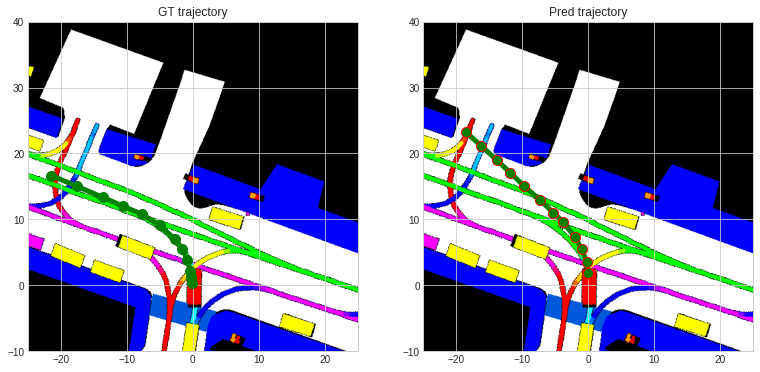

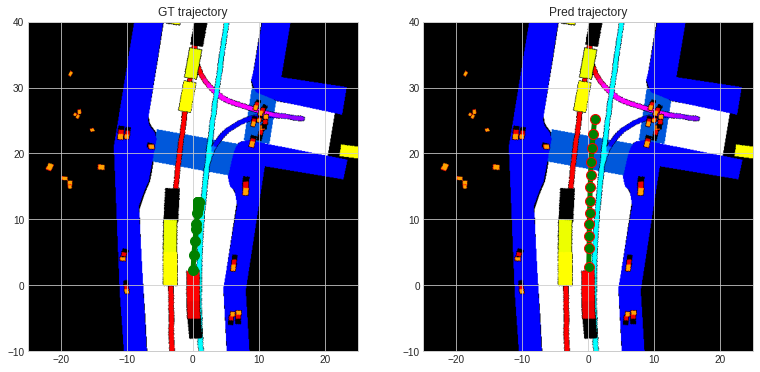

In [ ]:
# ---------- CoverNet GT and prediction ---------- #
if prediction_model == "CoverNet":

    # Helper initialization
    if nusc is None or "nusc" not in locals():
        nusc = NuScenes(
            version=DATASET_VERSION, dataroot=DATAROOT, verbose=True)
        helper = PredictHelper(nusc)
    indices = [10, 19]

    for idx in indices:
        # Data initialization
        (agent_state_vector, raster_img_static, raster_img_dynamic,
         gt_trajectory, idx) = test_dataset[idx]
        i_t, s_t = test_dataset.tokens[idx].split("_")
        future_indefinite = helper.get_future_for_agent(
            i_t, s_t, seconds=300, in_agent_frame=True)

        # Inference
        with torch.no_grad():
            reduced_traj = model.trajectories[:, :model.traj_samples].numpy()
            x_state, _, x_img, gt, _ = test_dataset[idx]
            x_state = x_state.to(device)
            x_img = x_img.to(device)
            x_state = torch.unsqueeze(torch.flatten(x_state, 0, 1), 0)
            x_img = torch.unsqueeze(x_img, 0)
            pred_logits = model((x_img, x_state))
            pred_probs = F.softmax(pred_logits, dim=1)[0]
            top_indices = pred_probs.argsort()[-MAX_PREDICTED_MODES:]
            cutted_probs = pred_probs[top_indices].cpu().numpy()
            predicted_traj = torch.from_numpy(
                reduced_traj[top_indices[0].cpu()]).numpy()

        # Plot
        plot_agent_future(
            raster_img_dynamic, future_indefinite, predicted_traj,
            agent_pos=(250, 380), reference_frame="local")

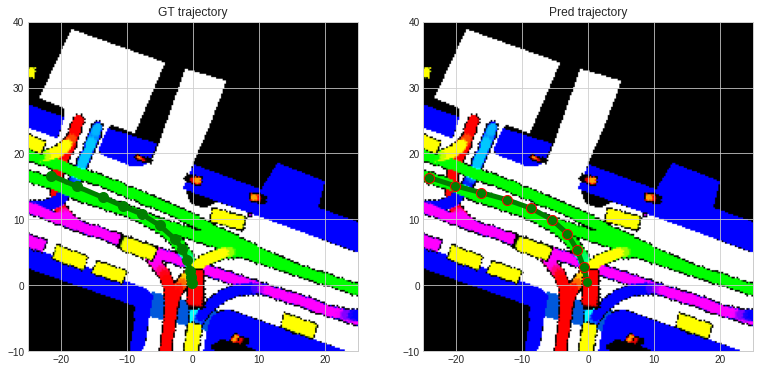

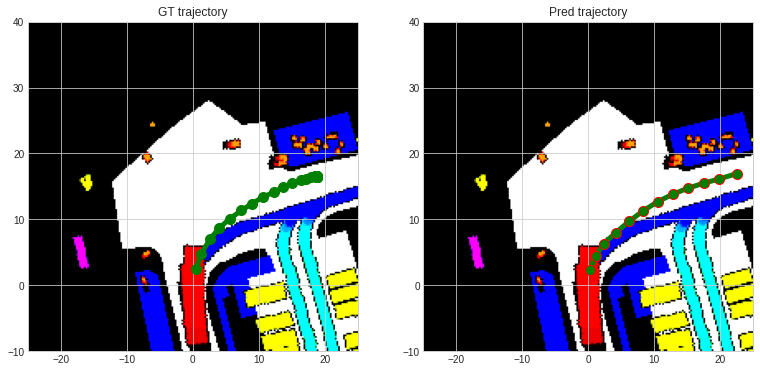

In [ ]:
# ---------- P2T GT and prediction ---------- #
if prediction_model == "P2T":
    indices = [10, 50]

    for idx in indices:
        # Data initialization
        data = (agent_state_vector, raster_img_static, raster_img_dynamic,
                gt_trajectory, idx, past, surr_agents, svf_e, plan_e,
                grid_idcs, motion_feats) = test_dataset[idx]
        data = [d.unsqueeze(0) if isinstance(d, torch.Tensor) else d
                for d in data]
        if test_dataset.helper is None:
            subfolder = f"batch_{idx//128}"
            add_data = np.load(os.path.join(
                DATAROOT, PREPROCESSED_ADV_FOLDER, "mini_val", subfolder,
                test_dataset.tokens[idx] + ADD_SUFFIX + ADDITIONAL_EXT),
                allow_pickle=True).item()
            future_indefinite = add_data["future_indefinite"]
        else:
            i_t, s_t = test_dataset.tokens[idx].split("_")
            future_indefinite = helper.get_future_for_agent(
                i_t, s_t, seconds=300, in_agent_frame=True)

        # Inference
        with torch.no_grad():
            (x_img_static, gt, past, motion_feats, _, agents, _) = \
                model.traj_data_preparation(data, device)
            model_input = (x_img_static, past, motion_feats, agents)
            traj_clust, probs_clust = model(model_input)
            traj_clust = traj_clust.squeeze(0).cpu().numpy()
            probs_clust = probs_clust.squeeze(0).cpu().numpy()
        top_indices = probs_clust.argsort()
        best_clust = traj_clust[top_indices[0]]

        # Plot
        plot_agent_future(raster_img_dynamic, future_indefinite, best_clust)

**Other results**

Here we show the intermediate results obtained after the P2T reward model's training phase

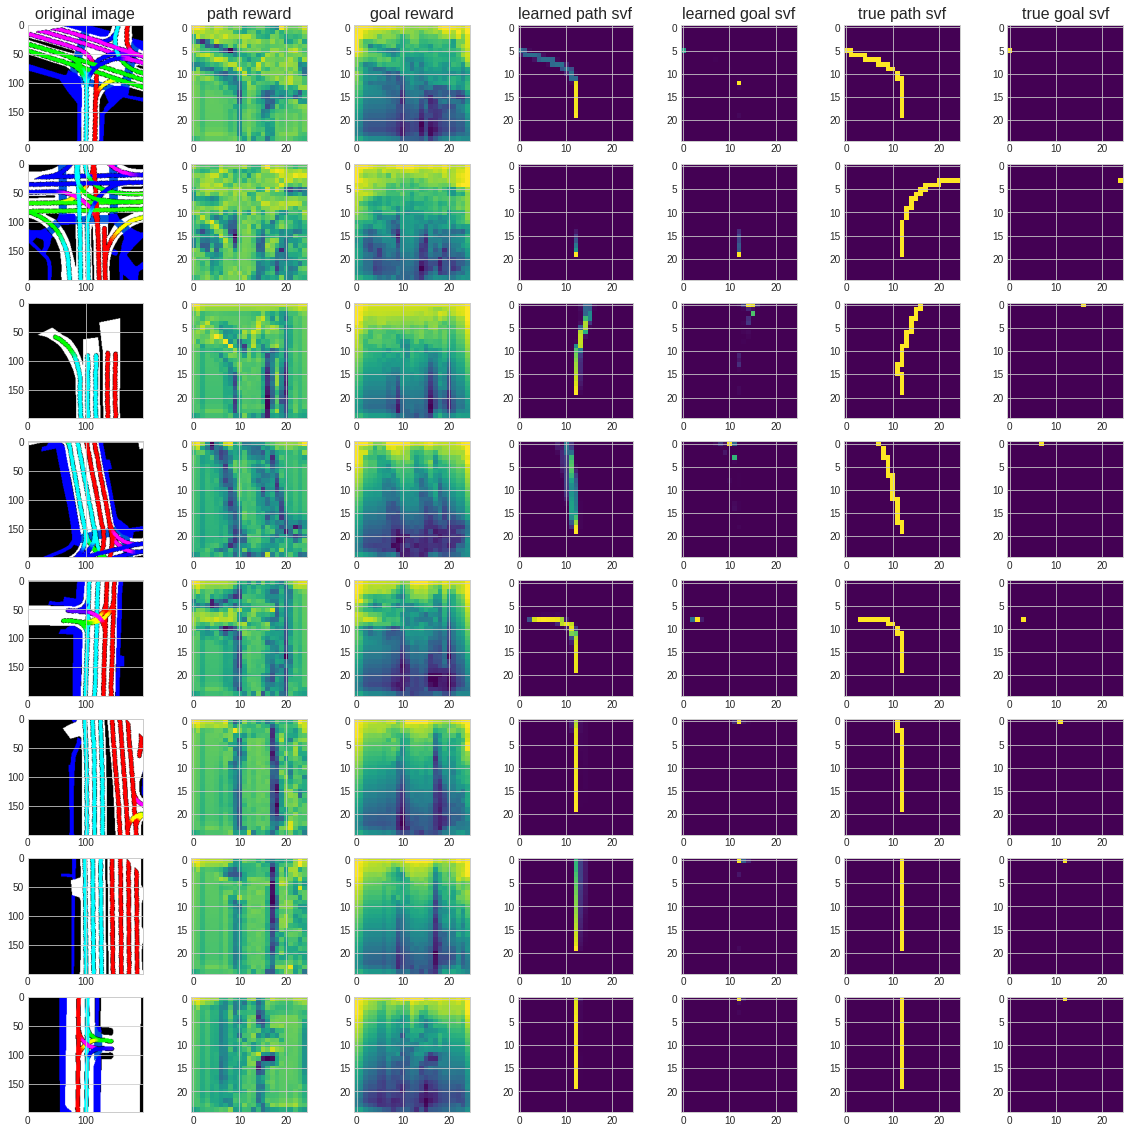

Here we show the same results, but with the reward model trained on the mini dataset and with different parameters for resolution and grid size

reward model results with half resolution and grid size <br>

<img src="https://drive.google.com/uc?id=17oEP-vq0qVvNJyEWruMiSHTlmY_sHnTk" 
width=500>


reward model results with double resolution and grid size <br>

<img src="https://drive.google.com/uc?id=1-hatt_XlxgZaXkEpt98jm5viCHBV_toS" width=500>


reward model results with standard resolution and grid size <br>

<img src="https://drive.google.com/uc?id=1K-w2QsJuVBDBgo6bSqupOnzFRluVulyV" width=500>



**The next cells show the training time for the two models on the mini dataset for a trajectory horizon of 6 seconds**

Here we show the plots of the loss for the training phase of the two models

Covernet training and validation with trajectory horizon of 6 seconds

<img src="https://drive.google.com/uc?id=1asfeWiKiB9nDabhyE9OLXzFusBjF1n9E" width=500>
<img src="https://drive.google.com/uc?id=1MA-lrlb7kLsVjuf8iHALZ27fCdu0G_Fj" width=500>


Covernet training and validation with trajectory horizon of 3 seconds

<img src="https://drive.google.com/uc?id=1P0hEeOj5dSVTOTcyR5frJqRjBE0fmx8a" width=500>
<img src="https://drive.google.com/uc?id=1LMfn3tMKylg0C0Y79Gkc7xfO7HkzhzS_" width=500>


P2T reward model training and validation

<img src="https://drive.google.com/uc?id=1IbfJ4xWVQhQCJz8HkS7PzPZ_v8TeQOwK" width=500>
<img src="https://drive.google.com/uc?id=1gUxA9nihhnNafTOGInphL_xs1covJKPK" width=500>
<img src="https://drive.google.com/uc?id=1iua8Fl2I7x5UtKXQ-149H3f03zNAflH5" width=500>


P2T pre-train trajectory generator training and validation with trajectory horizon of 6 seconds

<img src="https://drive.google.com/uc?id=1vPKS4qgdOQugp7cxRqrebui1FGthLkEe" width=500>
<img src="https://drive.google.com/uc?id=14Zw6K4AJmUO-Ek4FgGcBV8Mgm0Gb0MIj" width=500>


P2T fine-tune trajectory generator training and validation with trajectory horizon of 6 seconds

<img src="https://drive.google.com/uc?id=1WjV1YpxhRBj-pbzFkZiQ_Jps-V7sNGZG" width=500>
<img src="https://drive.google.com/uc?id=1sn5PcO8MDYxC7lR4BuO6wuNDLhSlssAu" width=500>


P2T pre-train trajectory generator training and validation with trajectory horizon of 3 seconds

<img src="https://drive.google.com/uc?id=13jz_TNnw17qceZQYh4VG8pyLK_mX5wDl" width=500>
<img src="https://drive.google.com/uc?id=1-kU1rW_LgFpxwtVVLqypMTCbFckModUF" width=500>


P2T fine-tune trajectory generator training and validation with trajectory horizon of 3 seconds

<img src="https://drive.google.com/uc?id=1JZpjH2UKapM3SHBjm3yM5sofer8FVG8O" width=500>
<img src="https://drive.google.com/uc?id=15evUAKWlDPjrhacF3-EV4jI6WR4dGz_j" width=500>


Note: different colored plot segments depend on different executions

In [ ]:
# Covernet training time distribution
print(nuScenesDataset.read_time_dict(model.time))

training = 711.713s
  cpu = 97.9%
  get_item = 9.5%
    indicize_token = 0.0%
    get_agent_raster = 56.7%
    load_gt = 7.9%
    normalization = 35.3%



In [ ]:
# P2t training time distribution
print(nuScenesDataset.read_time_dict(model.time))

training = 11516.708s
  cpu = 83.9%
  reward_model = 2.9%
  pre_traj_generator = 8.8%
  traj_generator = 83.3%
  get_item = 42.6%
    indicize_token = 0.0%
    get_agent_raster = 4.6%
    load_gt = 1.8%
    normalization = 4.0%
    nuscenesDataset = 10.6%
    expert_data = 6.4%
    add_data = 26.3%
    surrounding_agents = 20.5%
    agent_past = 15.9%
    future_indefinite = 1.6%
    motion_feats = 13.1%



## Code Debugging


Just for personal utility -> does not contribute to the principal code

**Dataset debugging**


In [ ]:
(agent_state_vector, raster_img_static, raster_img_dynamic,
 gt_trajectory, idx, past, surr_agents, svf_e, plan_e,
 grid_idcs, motion_feats) = train_dataset[0]

In [ ]:
print("**********************************************************************")
print("agent type =", agent_state_vector.dtype,
      "     | surr agents type =", surr_agents.dtype)
print("raster sta type =", raster_img_static.dtype,
      "| raster dyn type =", raster_img_dynamic.dtype)
print("gt type =", gt_trajectory.dtype, "        | idx type =",
      type(idx), "| past type =", past.dtype)
print("svf_e type =", svf_e.dtype, "     | plan_e type =", plan_e.dtype)
print("grid idcs type =", grid_idcs.dtype,
      " | motion feats type =", motion_feats.dtype)
print("**********************************************************************")

**********************************************************************
agent type = torch.float32      | surr agents type = torch.float32
raster sta type = torch.float32 | raster dyn type = torch.float32
gt type = torch.float64         | idx type = <class 'int'> | past type = torch.float32
svf_e type = torch.float32      | plan_e type = torch.float32
grid idcs type = torch.float32  | motion feats type = torch.float32
**********************************************************************


In [ ]:
agent_state_vector

tensor([[1.7065, 0.0000, 0.0000]])

In [ ]:
raster_img_static.shape

torch.Size([3, 200, 200])

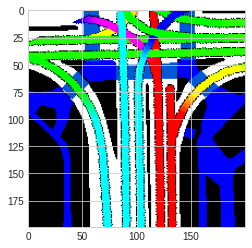

In [ ]:
plt.imshow(raster_img_static.permute(1, 2, 0))
plt.show()

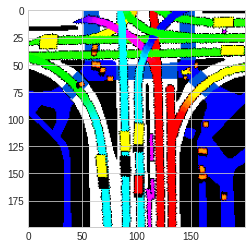

In [ ]:
plt.imshow(raster_img_dynamic.permute(1, 2, 0))
plt.show()

In [ ]:
gt_trajectory

tensor([[ 1.0751e-02,  2.4349e-01],
        [-2.0464e-01,  1.2052e+00],
        [-2.0399e-01,  2.5785e+00],
        [-2.5868e-01,  4.5031e+00],
        [-3.1359e-01,  6.6762e+00],
        [-3.1404e-01,  9.6773e+00],
        [-4.2374e-01,  1.2678e+01],
        [-4.2360e-01,  1.5844e+01],
        [-3.6769e-01,  1.8763e+01],
        [-2.6182e-02,  2.2007e+01],
        [ 5.3347e-01,  2.5213e+01],
        [ 1.4348e+00,  2.8401e+01]], dtype=torch.float64)

In [ ]:
idx

0

In [ ]:
past

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0720, -0.8500,  1.7065,  0.0000,  0.0000]])

In [ ]:
surr_agents.shape

torch.Size([4, 25, 25])

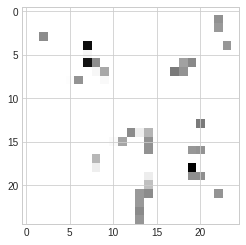

In [ ]:
plt.imshow(surr_agents[0])
plt.show()

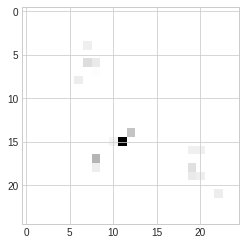

In [ ]:
plt.imshow(surr_agents[1])
plt.show()

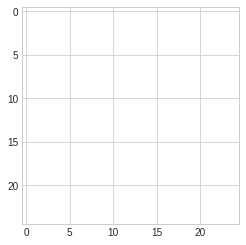

In [ ]:
plt.imshow(surr_agents[2])
plt.show()

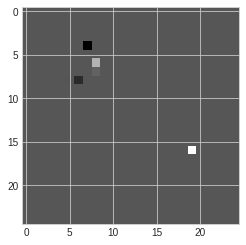

In [ ]:
plt.imshow(surr_agents[3])
plt.show()

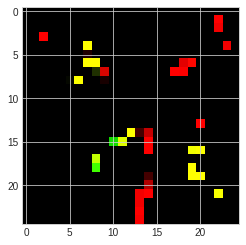

In [ ]:
plt.imshow(surr_agents[0:3].permute(1, 2, 0))
plt.show()

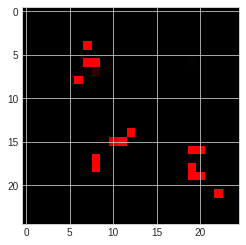

In [ ]:
plt.imshow(surr_agents[1:4].permute(1, 2, 0))
plt.show()

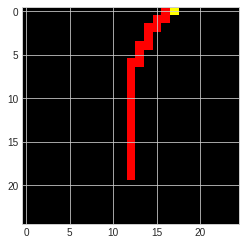

In [ ]:
svf_e_mod = torch.cat([svf_e, torch.zeros(1, 25, 25)])
plt.imshow(svf_e_mod.permute(1, 2, 0))
plt.show()

In [ ]:
plan_e.shape

torch.Size([40, 2])

In [ ]:
plan_e

tensor([[ 1.,  0.],
        [ 3.,  0.],
        [ 5.,  0.],
        [ 7.,  0.],
        [ 9.,  0.],
        [11.,  0.],
        [13.,  0.],
        [15.,  0.],
        [17.,  0.],
        [19.,  0.],
        [21.,  0.],
        [23.,  0.],
        [25.,  0.],
        [27.,  0.],
        [27.,  2.],
        [29.,  2.],
        [31.,  2.],
        [31.,  4.],
        [33.,  4.],
        [35.,  4.],
        [35.,  6.],
        [37.,  6.],
        [37.,  8.],
        [39.,  8.],
        [39., 10.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]])

In [ ]:
grid_idcs

tensor([[19., 12.],
        [18., 12.],
        [17., 12.],
        [16., 12.],
        [15., 12.],
        [14., 12.],
        [13., 12.],
        [12., 12.],
        [11., 12.],
        [10., 12.],
        [ 9., 12.],
        [ 8., 12.],
        [ 7., 12.],
        [ 6., 12.],
        [ 6., 13.],
        [ 5., 13.],
        [ 4., 13.],
        [ 4., 14.],
        [ 3., 14.],
        [ 2., 14.],
        [ 2., 15.],
        [ 1., 15.],
        [ 1., 16.],
        [ 0., 16.],
        [ 0., 17.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.]])

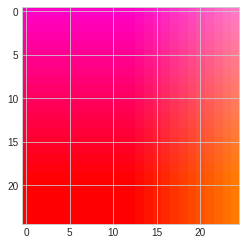

In [ ]:
plt.imshow(motion_feats.permute(1, 2, 0))
plt.show()

In [ ]:
motion_feats

tensor([[[ 1.7065,  1.7065,  1.7065,  ...,  1.7065,  1.7065,  1.7065],
         [ 1.7065,  1.7065,  1.7065,  ...,  1.7065,  1.7065,  1.7065],
         [ 1.7065,  1.7065,  1.7065,  ...,  1.7065,  1.7065,  1.7065],
         ...,
         [ 1.7065,  1.7065,  1.7065,  ...,  1.7065,  1.7065,  1.7065],
         [ 1.7065,  1.7065,  1.7065,  ...,  1.7065,  1.7065,  1.7065],
         [ 1.7065,  1.7065,  1.7065,  ...,  1.7065,  1.7065,  1.7065]],

        [[-0.4800, -0.4400, -0.4000,  ...,  0.4000,  0.4400,  0.4800],
         [-0.4800, -0.4400, -0.4000,  ...,  0.4000,  0.4400,  0.4800],
         [-0.4800, -0.4400, -0.4000,  ...,  0.4000,  0.4400,  0.4800],
         ...,
         [-0.4800, -0.4400, -0.4000,  ...,  0.4000,  0.4400,  0.4800],
         [-0.4800, -0.4400, -0.4000,  ...,  0.4000,  0.4400,  0.4800],
         [-0.4800, -0.4400, -0.4000,  ...,  0.4000,  0.4400,  0.4800]],

        [[ 0.7800,  0.7800,  0.7800,  ...,  0.7800,  0.7800,  0.7800],
         [ 0.7400,  0.7400,  0.7400,  ...,  0

**Network debugging - CoverNet**


In [ ]:
# Covernet Training loop (MANUAL - DEBUG ONLY)
if DEBUG_MODE:

    # Dataset preparation
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, drop_last=True)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, drop_last=True)

    # Training preparation
    optimizer = torch.optim.SGD(
        model.parameters(), lr=COVERNET_LR, momentum=COVERNET_MOMENTUM)
    model = model.to(device)

    # Plotting preparation
    train_loss_arr = []
    val_loss_arr = []
    train_iterations = len(train_dataset) // BATCH_SIZE
    val_iterations = len(val_dataset) // BATCH_SIZE

    # Training loop
    for i in range(TRAIN_EPOCHES):
        print("-------- Epoch %d --------" % i)
        model.train()

        # Training
        for j, data in enumerate(train_dataloader):

            # Data preparation
            x_state, x_img_static, x_img_dynamic, gt, idx = data
            x_state = x_state.to(device)
            x_img_static = x_img_static.to(device)
            x_img_dynamic = x_img_dynamic.to(device)
            x_state = torch.flatten(x_state, 0, 1)
            with torch.no_grad():
                reduced_traj = model.trajectories[
                    :, :SAMPLES_PER_SECOND*TRAJ_HORIZON]
                y = get_positives(reduced_traj, gt)

            # Inference
            optimizer.zero_grad()
            traj_logits = model((x_img_dynamic, x_state))
            y = y.to(device)
            loss = F.cross_entropy(traj_logits, y)
            loss.backward()
            optimizer.step()

            # Logging
            loss_val = loss.item()
            train_loss_arr.append(loss_val)
            print("[%d] %d - train loss = %f" % (i, j, loss_val))

        # Validation
        model.train(mode=False)
        for j, data in enumerate(val_dataloader):

            # Data preparation
            x_state, x_img_static, x_img_dynamic, gt, idx = data
            x_state = x_state.to(device)
            x_img_static = x_img_static.to(device)
            x_img_dynamic = x_img_dynamic.to(device)
            x_state = torch.flatten(x_state, 0, 1)
            reduced_traj = model.trajectories[
                :, :SAMPLES_PER_SECOND*TRAJ_HORIZON]
            y = get_positives(reduced_traj, gt)

            # Inference
            traj_logits = model((x_img_dynamic, x_state))
            y = y.to(device)
            loss = F.cross_entropy(traj_logits, y)

            # Logging
            loss_val = loss.item()
            val_loss_arr.append(loss_val)
            print("[%d] %d - val loss = %f" % (i, j, loss_val))

        # Plotting
        if (i+1) % PLOT_PERIOD == 0:
            plot_train_data(train_iterations, val_iterations,
                            i+1, train_loss_arr, val_loss_arr)
            a = input("Press Enter to continue...")
            plt.close("all")